In [1]:
from paths import models_folder, metadata_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20756'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1024'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20608'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_8_B1H_Inst_252'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_16_8_stride_4_B1H_Inst_253'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst_jorg'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_strid

In [6]:
model_path = models_folder / "model_conv_32_16_8_stride_4_B1H_Inst_presplit_center_scale_100_seed_42"

In [7]:
list(model_path.glob('*fetched*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_stride_4_B1H_Inst_presplit_center_scale_100_seed_42/validation_fetched.npy'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_stride_4_B1H_Inst_presplit_center_scale_100_seed_42/train_fetched.npy')]

# Load model and associated generators

In [8]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
train_seen_indices = np.load(model_path / "train_fetched.npy")
validation_seen_indices = np.load(model_path / "validation_fetched.npy")

# train/validation split
# train_split_indices = np.load(model_path / "train_split_indices.npy")
# validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_seen_indices]
validation_metadata = data_metadata_df.iloc[validation_seen_indices]

# the training loss history
hist = model_metadata["history"]

# remove shuffling
model_metadata["generator"]["shuffle"] = True  # True because I don't have the seen values indices
# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"])
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 512, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 16)           3600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 8)             904       
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 128, 8)            456       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 8)            0

Feb/23 14:03:58 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/23 14:03:58 pyobsbox.generator INFO: shuffle: True
Feb/23 14:03:58 pyobsbox.generator INFO: seed: 42
Feb/23 14:03:58 pyobsbox.generator INFO: batch_size: 8192
Feb/23 14:03:58 pyobsbox.generator INFO: sequence_length: 2048
Feb/23 14:03:58 pyobsbox.generator INFO: n_bunches: 256
Feb/23 14:03:58 pyobsbox.generator INFO: __len__: 1040
Feb/23 14:03:58 pyobsbox.generator INFO: fetched_log_folder: None
Feb/23 14:03:58 pyobsbox.generator INFO: fetched_log_prefix: 
Feb/23 14:03:58 pyobsbox.generator INFO: normalization: center_scale
Feb/23 14:03:58 pyobsbox.generator INFO: normalization_pre_split: True
Feb/23 14:03:58 pyobsbox.generator INFO: normalization_kwargs: {'scale_factor': 100}
Feb/23 14:03:58 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/23 14:03:58 pyobsbox.g

In [9]:
print(train_metadata.shape)
train_metadata.head()

(266240, 11)


,type,fill,beam,plane,q,date_time,file,n_bunches,bunch_index,bunch_number,ts_length
7245435,Inst,6859,1,h,7,2018-06-28 13:38:48,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6859/...,684,912.0,666.0,65536
6888953,Inst,6703,1,h,7,2018-05-20 03:39:14,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6703/...,396,327.0,207.0,65536
1617606,Inst,6663,1,h,7,2018-05-10 15:13:15,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/...,2556,1627.0,1195.0,65536
6141021,Inst,6711,1,h,7,2018-05-22 15:04:14,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6711/...,2556,3334.0,2465.0,65536
593968,Inst,6245,1,h,7,2017-09-26 15:54:15,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...,1916,2843.0,1575.0,65536


In [10]:
print(validation_metadata.shape)
validation_metadata.head()

(3840, 11)


,type,fill,beam,plane,q,date_time,file,n_bunches,bunch_index,bunch_number,ts_length
11638185,Inst,6849,1,h,7,2018-06-26 18:39:15,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6849/...,603,2160.0,399.0,65536
1886810,Inst,6890,1,h,7,2018-07-05 17:49:14,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/...,1452,1276.0,534.0,65536
7133690,Inst,6616,1,h,7,2018-04-27 03:56:14,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6616/...,746,1053.0,286.0,65536
5356507,Inst,6639,1,h,7,2018-05-03 16:41:40,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6639/...,2319,3283.0,2317.0,65536
2823933,Inst,7063,1,h,7,2018-08-18 14:53:12,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7063/...,1068,497.0,351.0,65536


# Loss functions

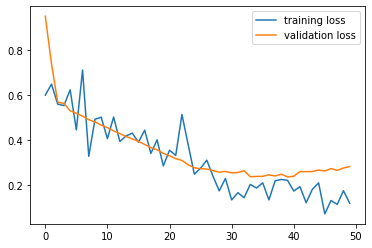

In [11]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [12]:
train_dataset = np.vstack([train_generator[i][0] for i in tqdm(range(50))])
train_dataset.shape

(409600, 2048, 1)

In [13]:
validation_dataset = np.vstack([validation_generator[i][0] for i in tqdm(range(5))])
validation_dataset.shape

(40960, 2048, 1)

# Predictions

In [14]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

50/50 [==============================] - 63s 1s/step


(409600, 2048, 1)

In [15]:
validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
validation_pred.shape

5/5 [==============================] - 5s 1s/step


(40960, 2048, 1)

In [16]:
MAE_train = abs(train_pred - train_dataset).mean(axis=1).squeeze()
MAE_train.shape

(409600,)

In [17]:
MAE_validation = abs(validation_pred - validation_dataset).mean(axis=1).squeeze()
MAE_validation.shape

(40960,)

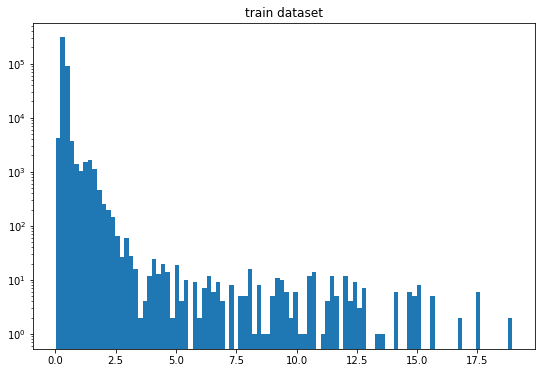

In [18]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
plt.yscale('log')

rough peak

In [19]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.2120308968272992

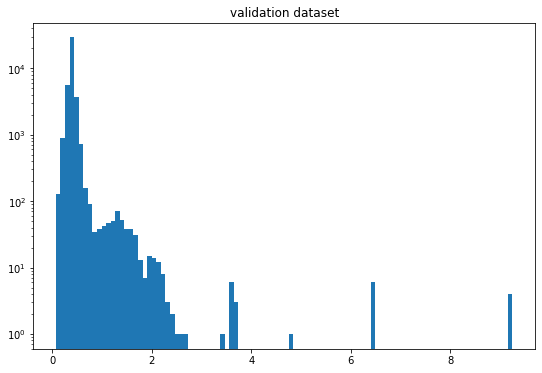

In [20]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_validation, bins=100)
plt.title("validation dataset")
plt.yscale('log')

In [21]:
hist_peak_validation = bins[n.argmax()]
hist_peak_validation

0.343904036162235

In [22]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [23]:
max_MAE_indices

array([356654, 359735,  60686, ..., 391054, 391052, 392704])

In [24]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal)
    axes[0].plot(pred_signal)

    axes[1].plot(np.abs(np.diff(true_signal)))
    axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

index:  356654
MAE:  18.949226066423584
n_bunches       1188
bunch_index      909
bunch_number     488
Name: 6814885, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6184/instability_data/06184_Inst_B1H_Q7_20170909_23h52m01s.h5


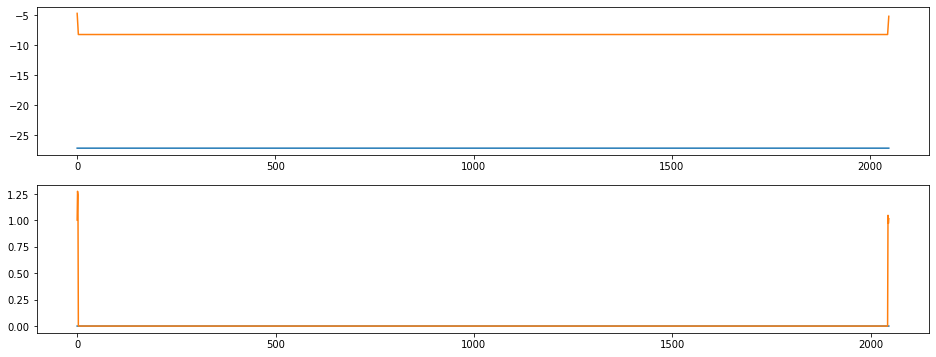

In [25]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal);

# Top rightmost signals

index:  356654
MAE:  18.949226066423584
n_bunches       1188
bunch_index      909
bunch_number     488
Name: 6814885, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6184/instability_data/06184_Inst_B1H_Q7_20170909_23h52m01s.h5


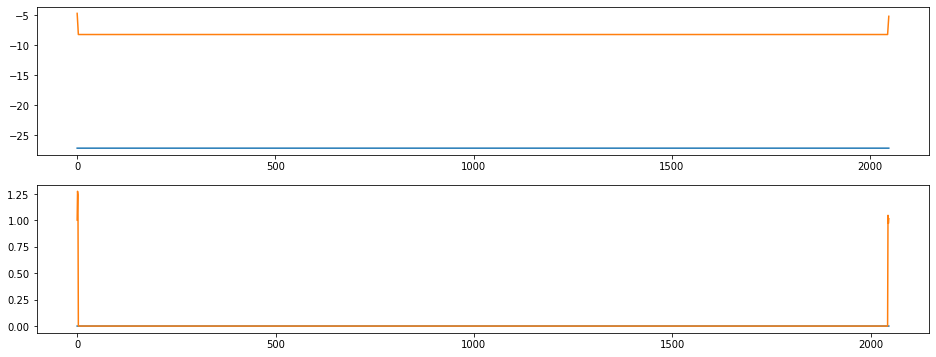

index:  359735
MAE:  18.949226066423584
n_bunches       524
bunch_index     610
bunch_number    113
Name: 1807058, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6381/instability_data/06381_Inst_B1H_Q7_20171112_08h01m20s.h5


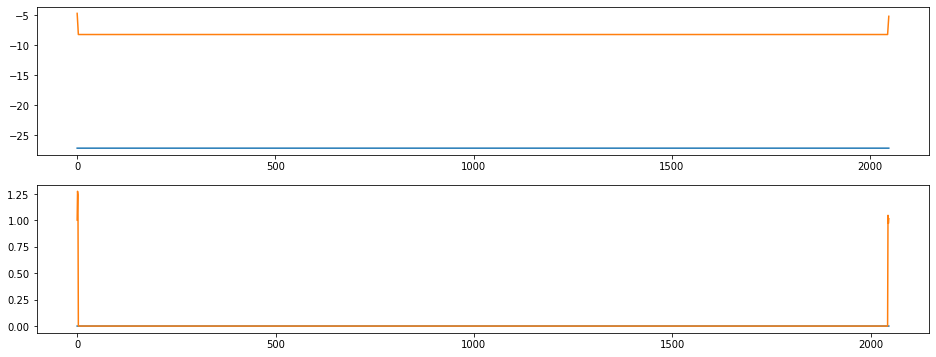

index:  60686
MAE:  17.578441255302174
n_bunches       2556
bunch_index     2213
bunch_number    1618
Name: 6406087, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6709/instability_data/06709_Inst_B1H_Q7_20180520_23h54m15s.h5


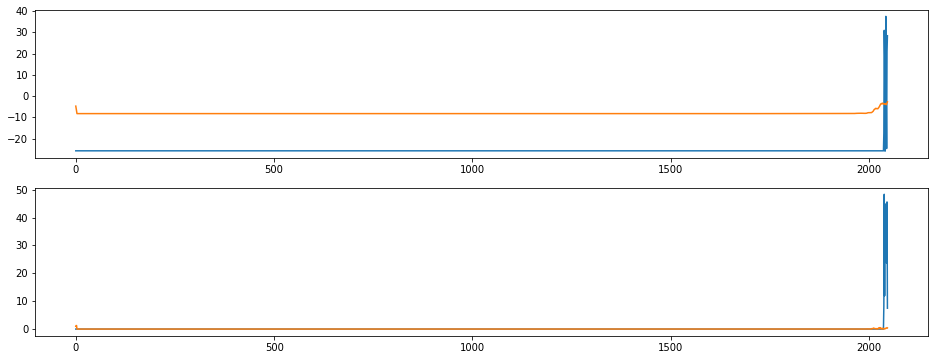

index:  63527
MAE:  17.51298751051538
n_bunches       924
bunch_index     529
bunch_number    364
Name: 1520834, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6738/instability_data/06738_Inst_B1H_Q7_20180529_00h10m07s.h5


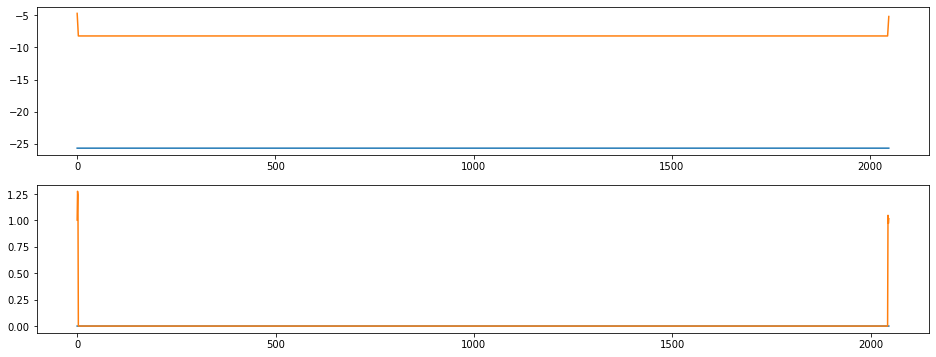

index:  60559
MAE:  17.51298751051538
n_bunches       2556
bunch_index     1419
bunch_number    1032
Name: 9992290, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_10h59m14s.h5


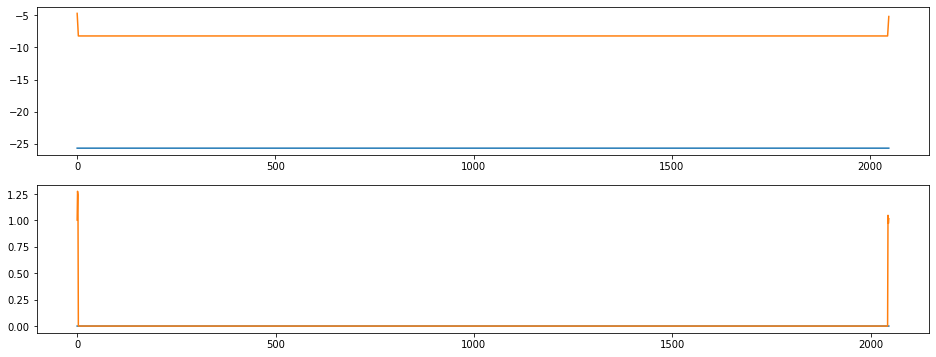

index:  59670
MAE:  17.51298751051538
n_bunches       540
bunch_index     925
bunch_number    277
Name: 9388191, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7182/instability_data/07182_Inst_B1H_Q7_20180915_17h48m02s.h5


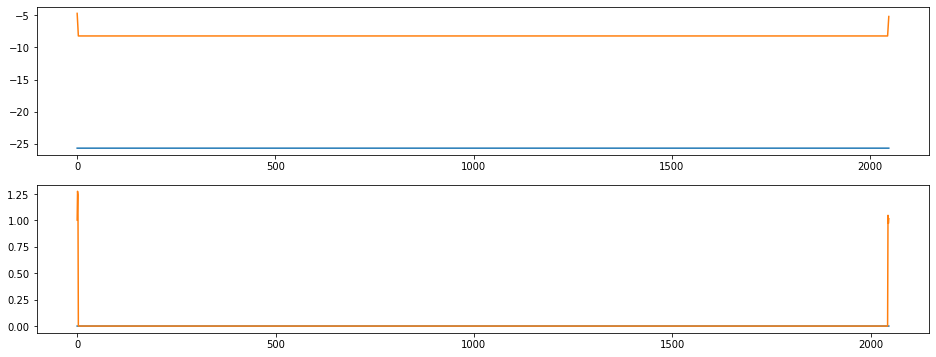

index:  63998
MAE:  17.51298751051538
n_bunches       2556
bunch_index      439
bunch_number     288
Name: 11208931, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6757/instability_data/06757_Inst_B1H_Q7_20180604_11h54m15s.h5


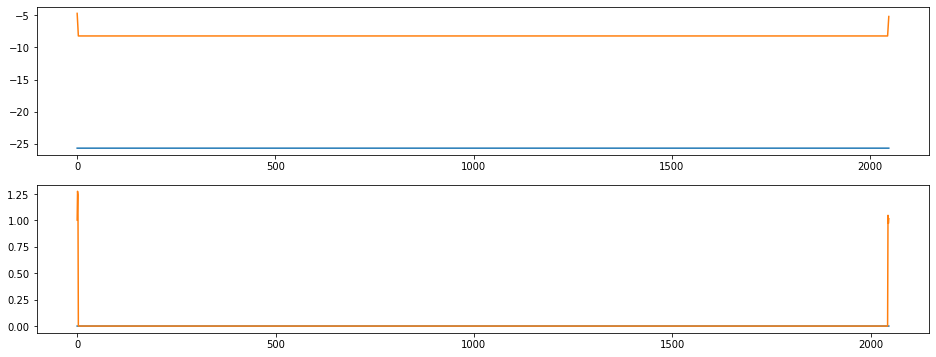

index:  62306
MAE:  17.51298751051538
n_bunches       1452
bunch_index     3296
bunch_number    1400
Name: 8205347, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180705_19h28m14s.h5


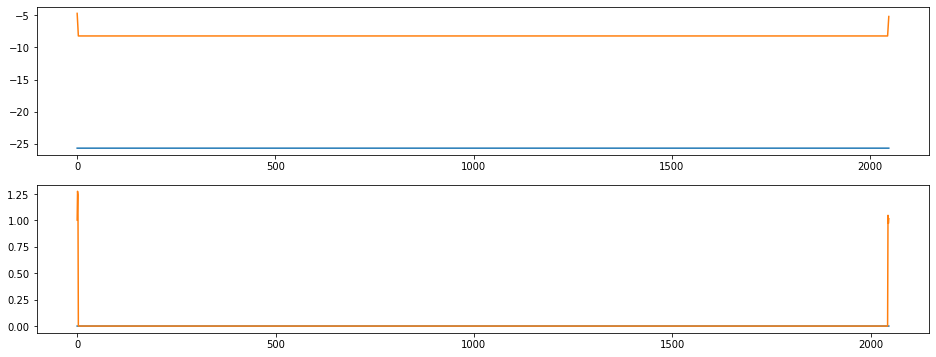

index:  377186
MAE:  16.827916709734126
n_bunches       780
bunch_index     283
bunch_number    189
Name: 845391, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7245/instability_data/07245_Inst_B1H_Q7_20181002_00h23m38s.h5


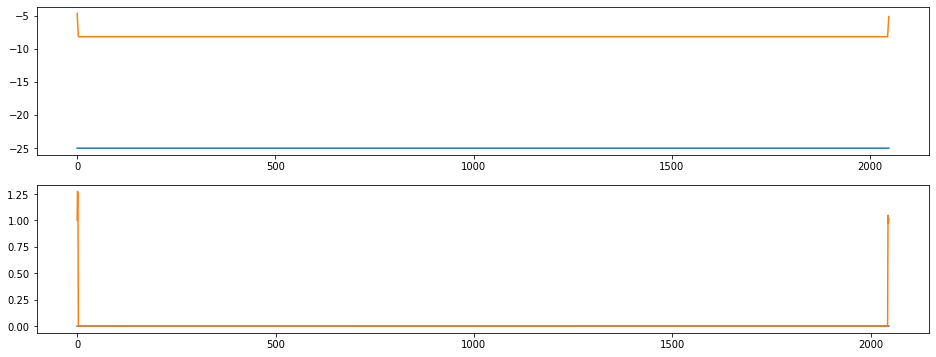

index:  380046
MAE:  16.827916709734126
n_bunches       1916
bunch_index     1328
bunch_number     727
Name: 11028177, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6243/instability_data/06243_Inst_B1H_Q7_20170925_21h04m59s.h5


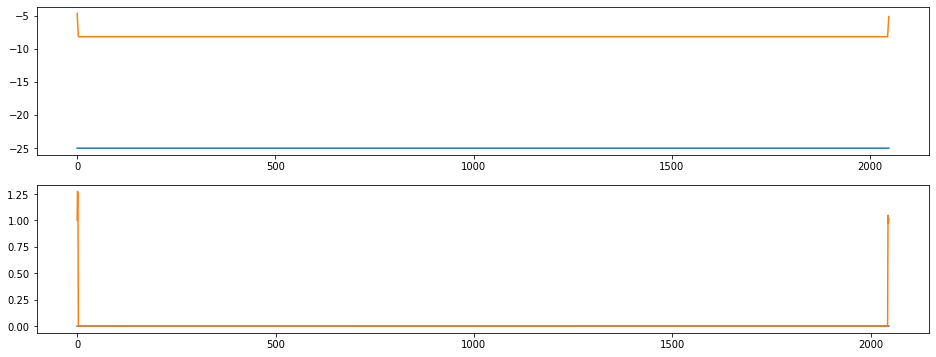

In [26]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Top leftmost signals

index:  392704
MAE:  0.022766299154609454
n_bunches        733
bunch_index     2291
bunch_number     484
Name: 1437707, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7467/instability_data/07467_Inst_B1H_Q7_20181123_10h37m15s.h5


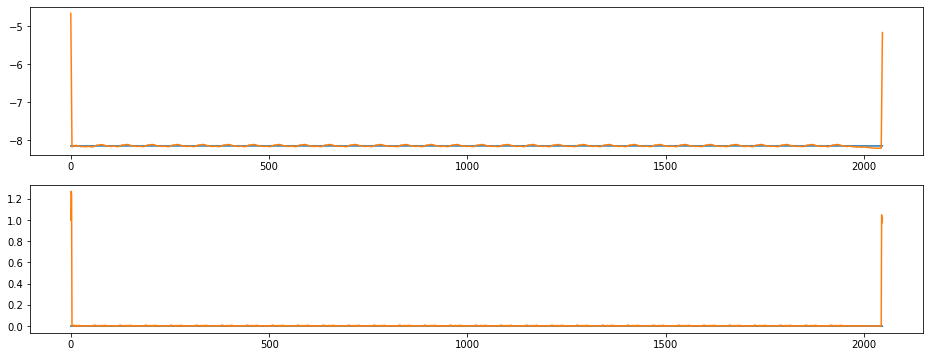

index:  391052
MAE:  0.022766299154609454
n_bunches       1868
bunch_index     2131
bunch_number    1139
Name: 1781577, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6348/instability_data/06348_Inst_B1H_Q7_20171031_01h41m14s.h5


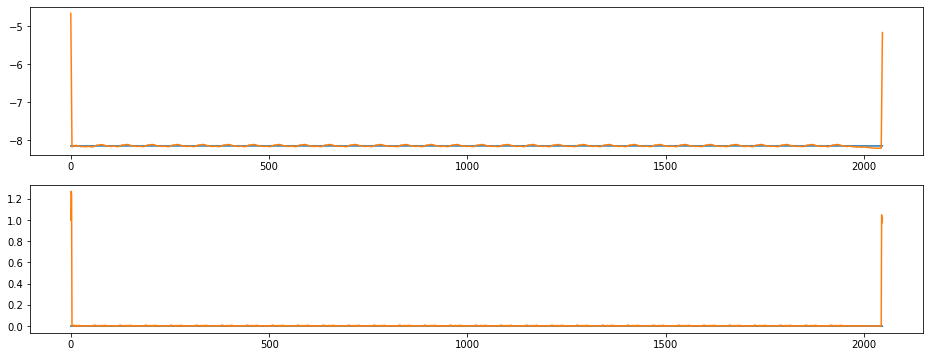

index:  391054
MAE:  0.022766299154609454
n_bunches       1868
bunch_index     2131
bunch_number    1139
Name: 1781577, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6348/instability_data/06348_Inst_B1H_Q7_20171031_01h41m14s.h5


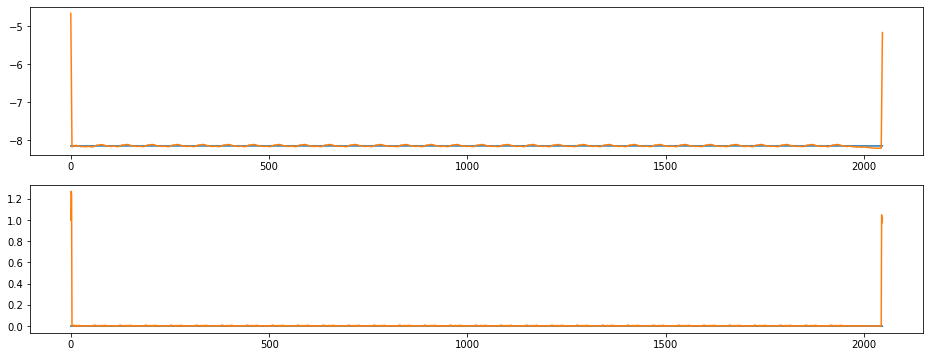

index:  386827
MAE:  0.022766299154609454
n_bunches       1212
bunch_index     1169
bunch_number     853
Name: 10664987, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7122/instability_data/07122_Inst_B1H_Q7_20180903_07h36m05s.h5


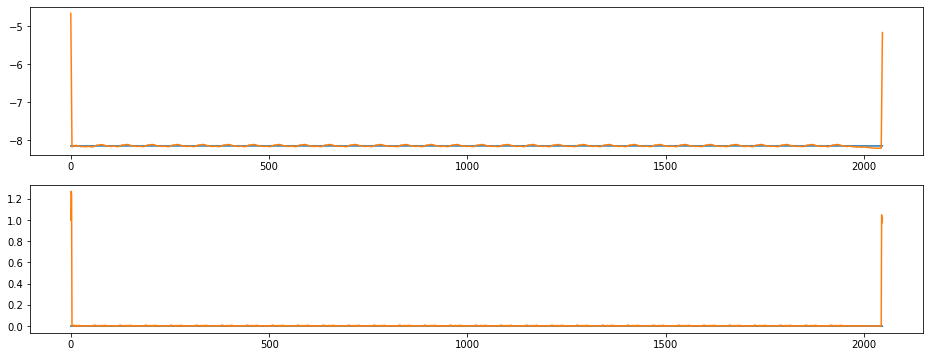

index:  388360
MAE:  0.022766299154609454
n_bunches       1551
bunch_index      555
bunch_number     351
Name: 4991367, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6628/instability_data/06628_Inst_B1H_Q7_20180501_03h41m14s.h5


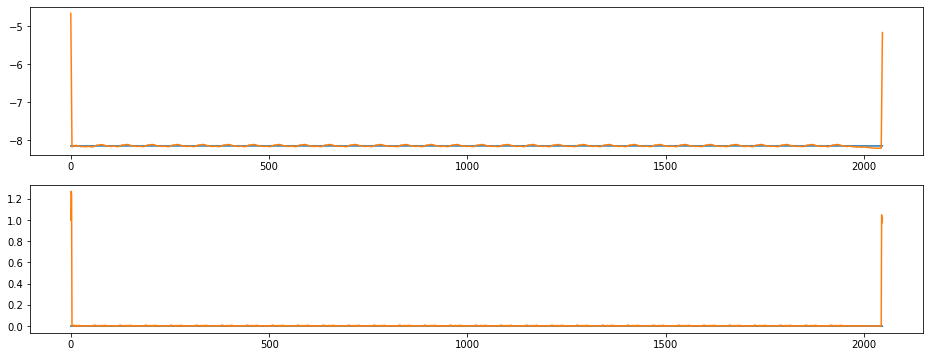

index:  390524
MAE:  0.022766299154609454
n_bunches       292
bunch_index     101
bunch_number     47
Name: 643337, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6254/instability_data/06254_Inst_B1H_Q7_20170929_05h24m15s.h5


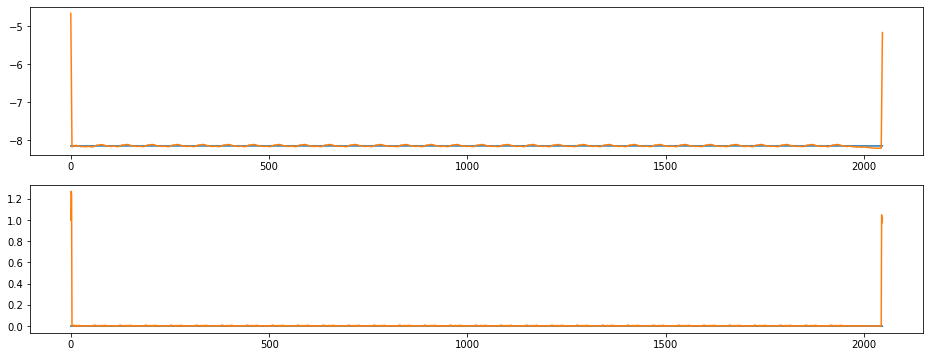

index:  387456
MAE:  0.022766299154609454
n_bunches       540
bunch_index     597
bunch_number    401
Name: 7797585, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6757/instability_data/06757_Inst_B1H_Q7_20180604_04h17m22s.h5


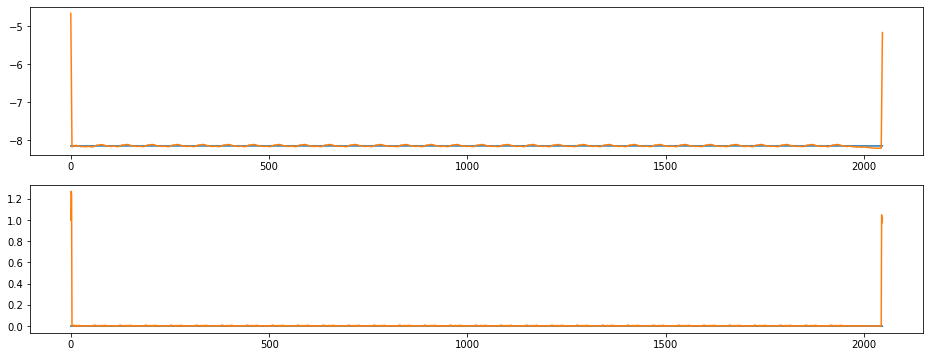

index:  387209
MAE:  0.022766299154609454
n_bunches       1068
bunch_index       24
bunch_number       6
Name: 1381145, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7117/instability_data/07117_Inst_B1H_Q7_20180902_03h37m59s.h5


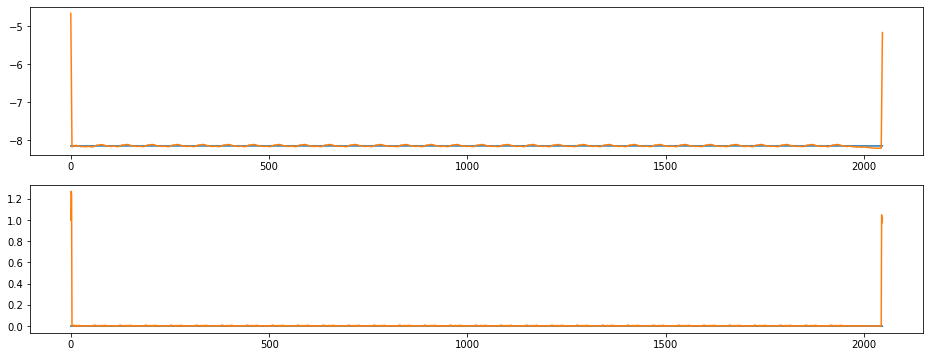

index:  388950
MAE:  0.022766299154609454
n_bunches       1068
bunch_index       83
bunch_number      15
Name: 299002, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6709/instability_data/06709_Inst_B1H_Q7_20180520_21h01m56s.h5


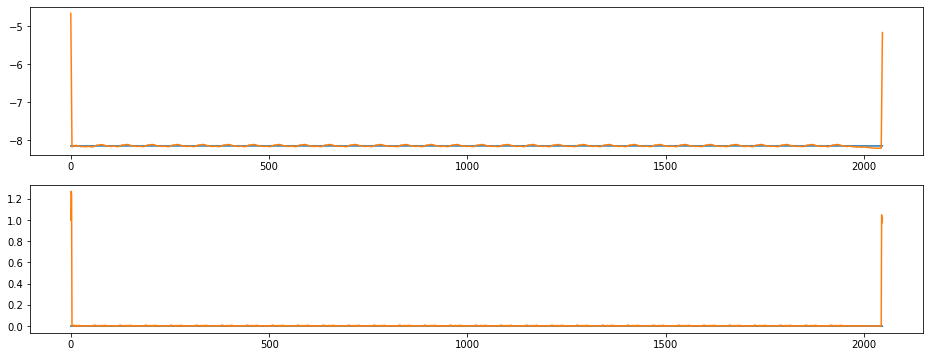

index:  387873
MAE:  0.022766299154609454
n_bunches       733
bunch_index      73
bunch_number     10
Name: 4972978, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7475/instability_data/07475_Inst_B1H_Q7_20181126_17h56m14s.h5


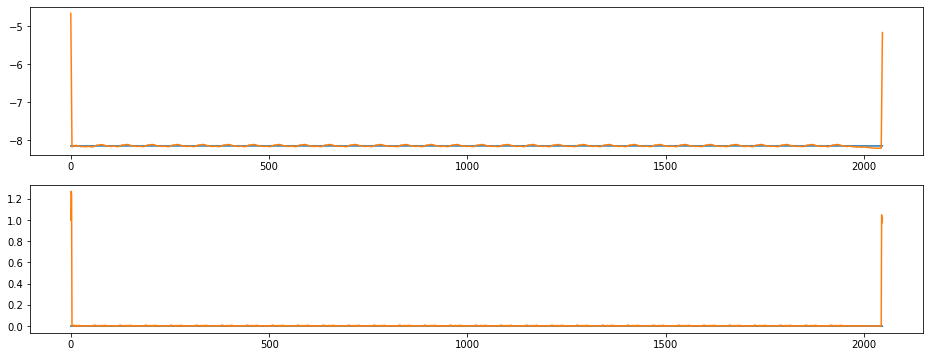

In [27]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Signals around the peak

In [28]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

index:  78676
MAE:  0.2120251662601368
n_bunches       1358
bunch_index     1296
bunch_number     494
Name: 8746238, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6239/instability_data/06239_Inst_B1H_Q7_20170924_06h52m14s.h5


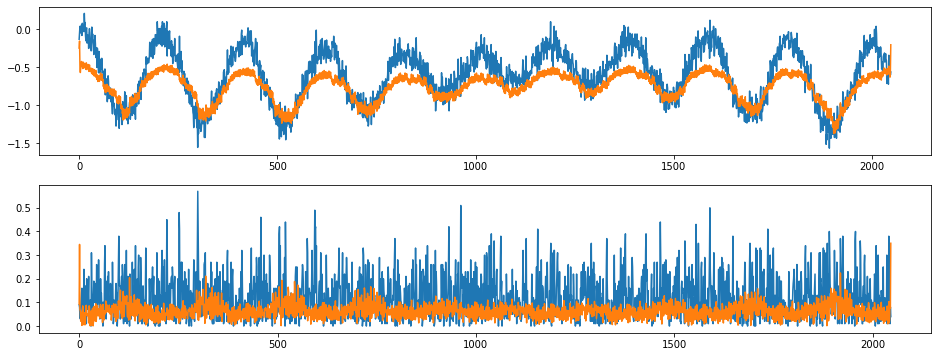

index:  202152
MAE:  0.21200643264746757
n_bunches       1887
bunch_index     1045
bunch_number     577
Name: 2996676, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6693/instability_data/06693_Inst_B1H_Q7_20180517_04h59m13s.h5


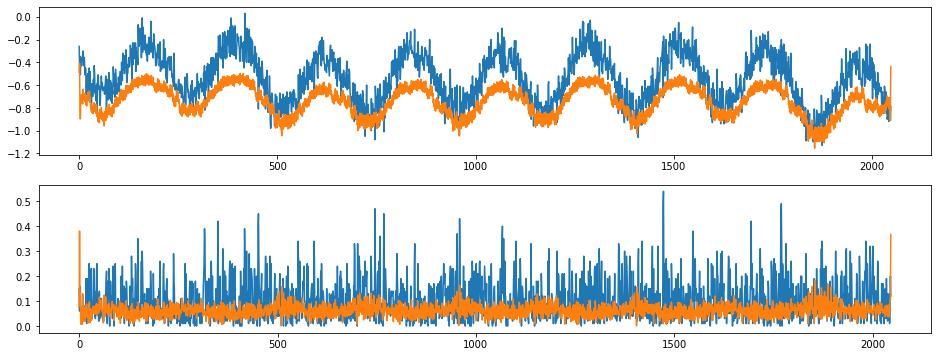

index:  387762
MAE:  0.21206340666132745
n_bunches       1068
bunch_index       73
bunch_number      24
Name: 437851, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7122/instability_data/07122_Inst_B1H_Q7_20180903_07h34m50s.h5


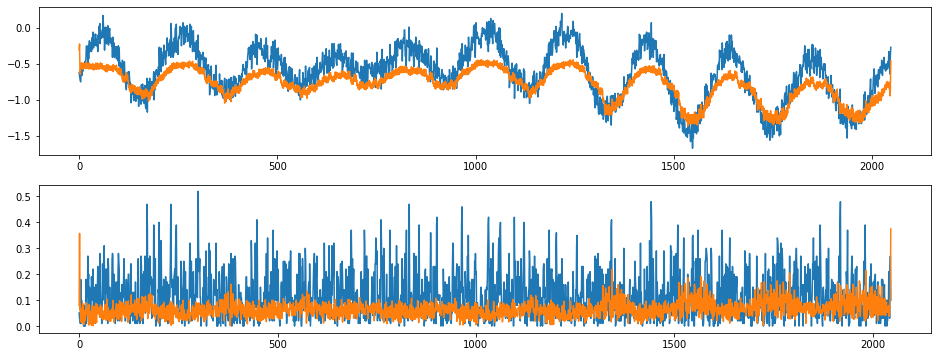

index:  208898
MAE:  0.21206559147685766
n_bunches       1836
bunch_index     2687
bunch_number    1434
Name: 11282121, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_11h11m13s.h5


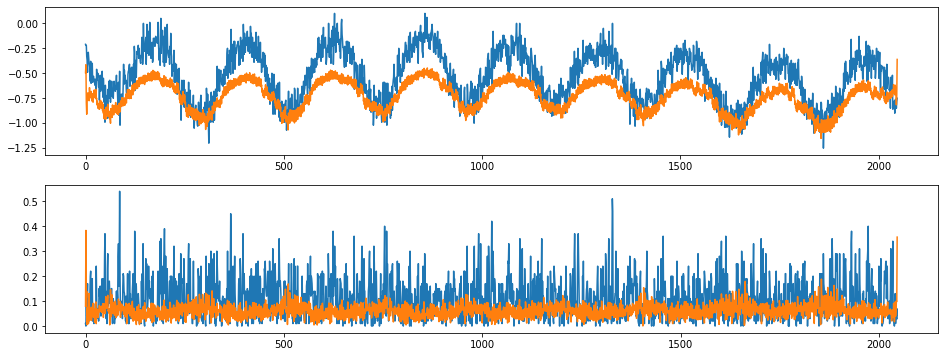

index:  174954
MAE:  0.21206844747037396
n_bunches        648
bunch_index     2255
bunch_number     420
Name: 8226371, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7483/instability_data/07483_Inst_B1H_Q7_20181129_10h48m14s.h5


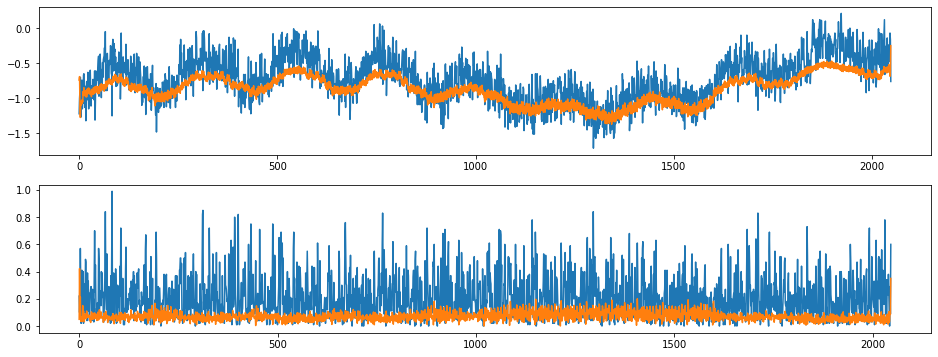

index:  39930
MAE:  0.21207989162765445
n_bunches       1551
bunch_index     2235
bunch_number    1027
Name: 2079379, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6628/instability_data/06628_Inst_B1H_Q7_20180501_05h56m14s.h5


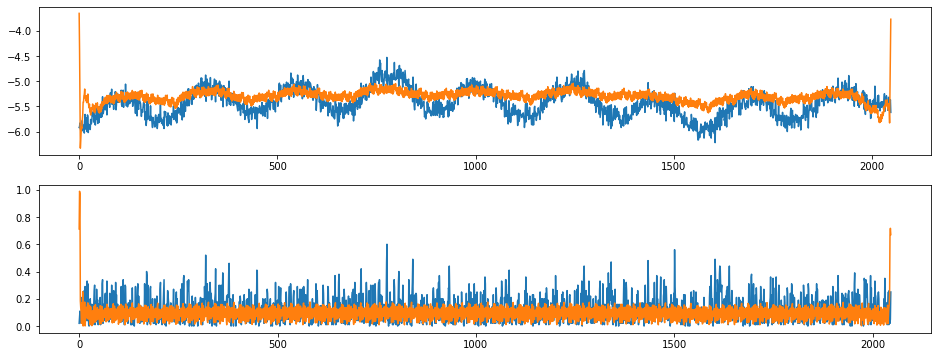

index:  82809
MAE:  0.2120819891768042
n_bunches       1916
bunch_index     3302
bunch_number    1823
Name: 8909064, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_23h45m15s.h5


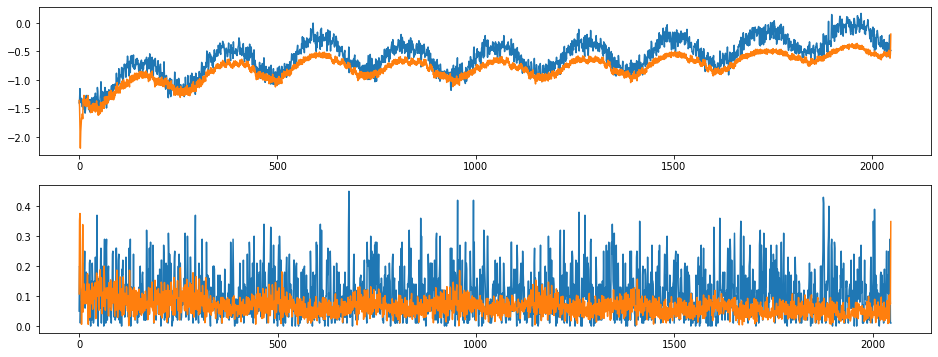

index:  327490
MAE:  0.2119788591063116
n_bunches       636
bunch_index     449
bunch_number    310
Name: 3111300, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7265/instability_data/07265_Inst_B1H_Q7_20181007_22h28m19s.h5


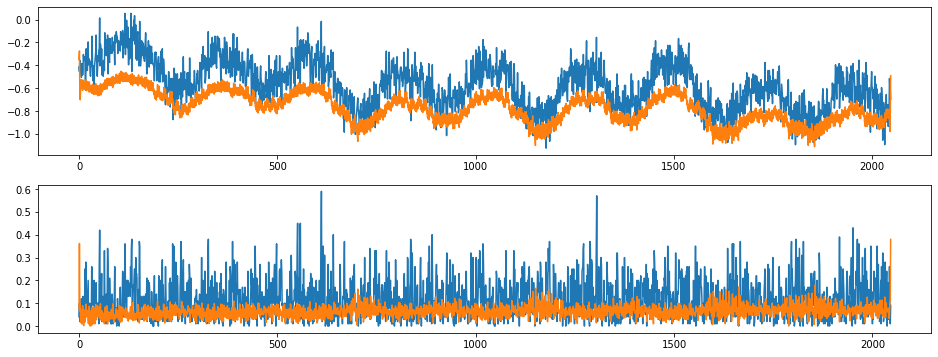

index:  47349
MAE:  0.21196937261527637
n_bunches       2556
bunch_index      405
bunch_number     254
Name: 11373739, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_15h11m14s.h5


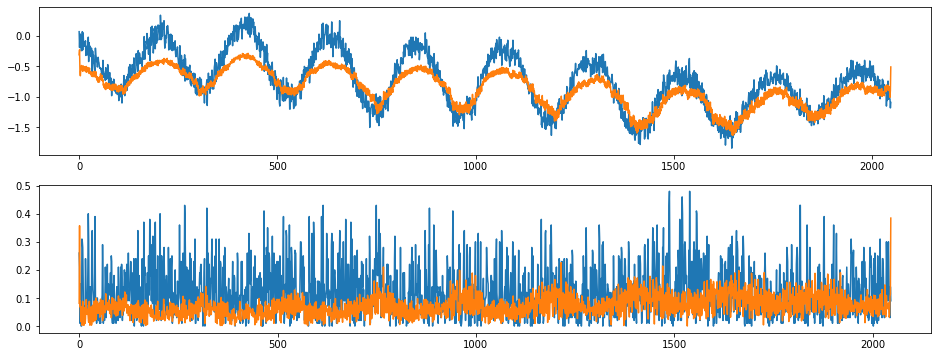

index:  217246
MAE:  0.21196891163883264
n_bunches       636
bunch_index     265
bunch_number    171
Name: 11129870, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7097/instability_data/07097_Inst_B1H_Q7_20180828_14h25m14s.h5


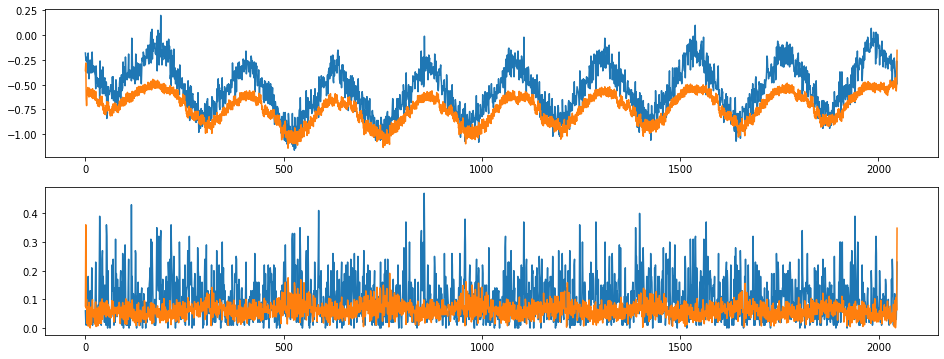

In [29]:
for i in range(10):
    around_peak_index = around_peak_indices[i]

    print('index: ', around_peak_index)
    print("MAE: ", MAE_train[around_peak_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_peak_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_peak_index].squeeze()
    pred_signal = train_pred[around_peak_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# around a point

In [30]:
around_point_indices = np.argsort(np.abs(MAE_train - 0.6))

index:  87022
MAE:  0.599997206669068
n_bunches       506
bunch_index       3
bunch_number      3
Name: 9698535, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6618/instability_data/06618_Inst_B1H_Q7_20180428_03h58m13s.h5


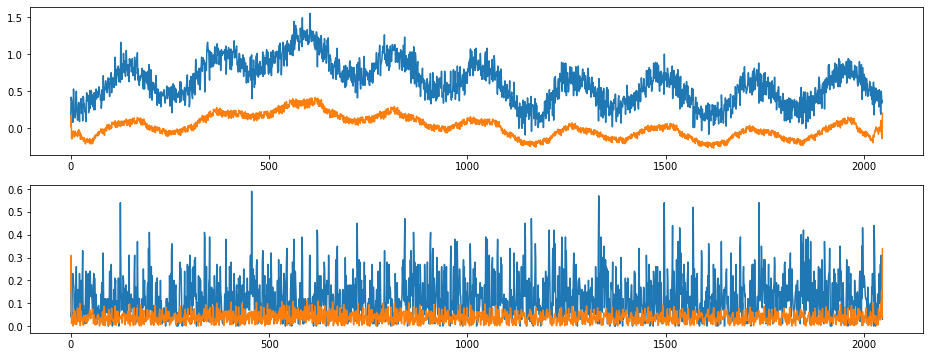

index:  325474
MAE:  0.600002825812262
n_bunches       2175
bunch_index     1999
bunch_number    1296
Name: 4611949, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6694/instability_data/06694_Inst_B1H_Q7_20180517_10h57m14s.h5


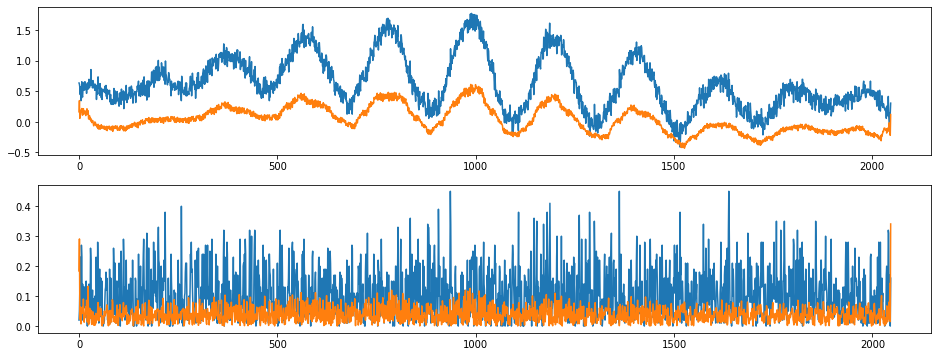

index:  6677
MAE:  0.5999939341933349
n_bunches       540
bunch_index     707
bunch_number    516
Name: 99392, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7271/instability_data/07271_Inst_B1H_Q7_20181009_17h14m19s.h5


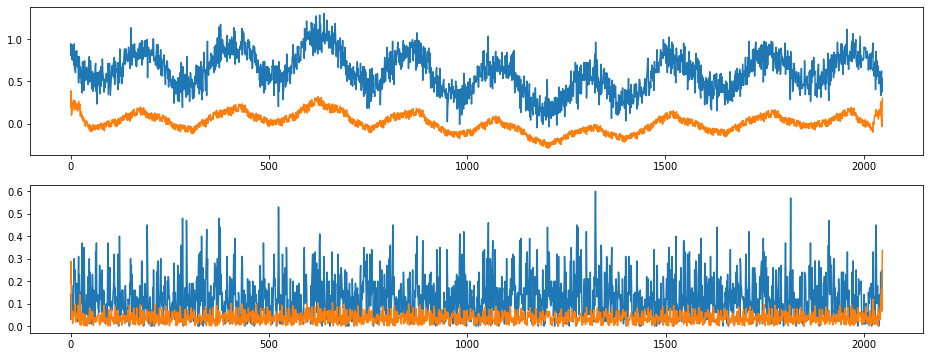

index:  278155
MAE:  0.600049174357846
n_bunches       2556
bunch_index     1157
bunch_number     841
Name: 10238162, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6923/instability_data/06923_Inst_B1H_Q7_20180714_21h05m14s.h5


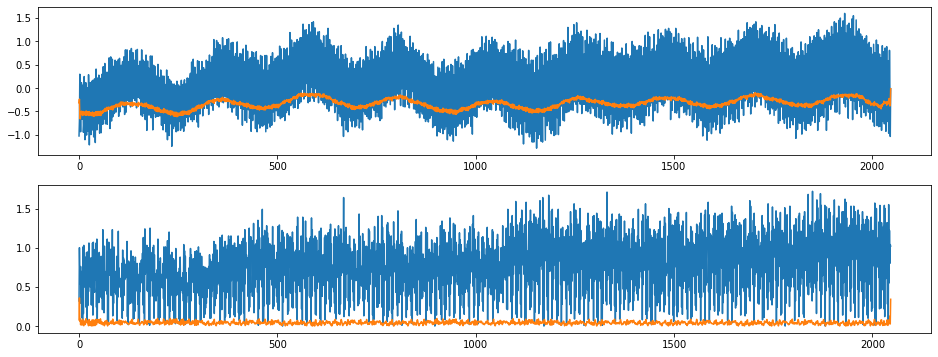

index:  408423
MAE:  0.6000576413836097
n_bunches       2556
bunch_index     1832
bunch_number    1346
Name: 3177913, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7101/instability_data/07101_Inst_B1H_Q7_20180830_01h49m14s.h5


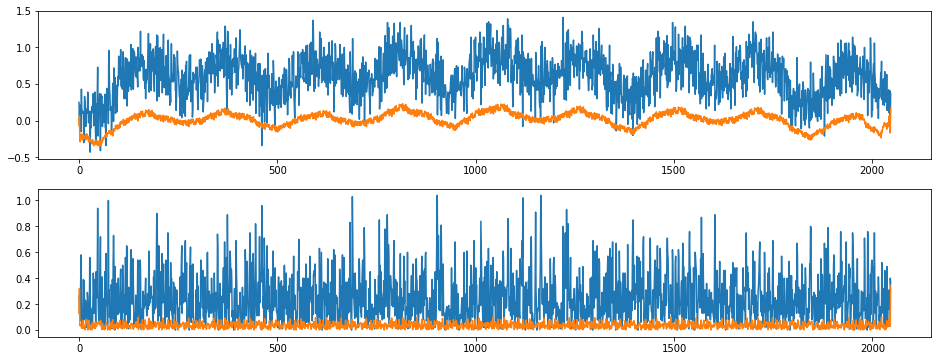

index:  265142
MAE:  0.5999415199115173
n_bunches       2175
bunch_index     3162
bunch_number    2066
Name: 4984842, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6694/instability_data/06694_Inst_B1H_Q7_20180517_10h01m14s.h5


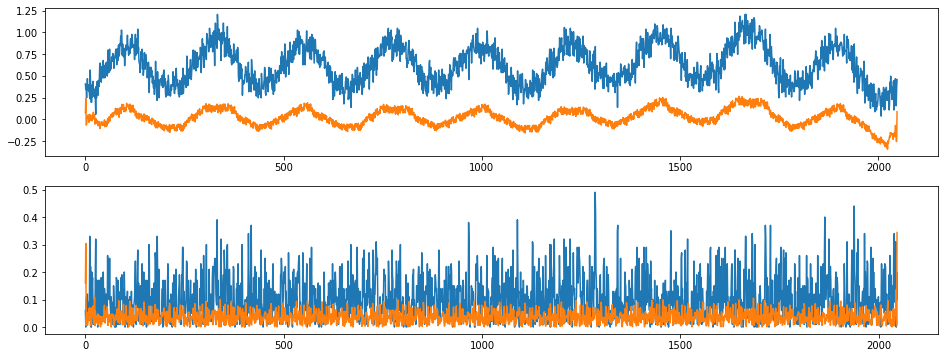

index:  170994
MAE:  0.5999389693212288
n_bunches       1868
bunch_index     1898
bunch_number    1006
Name: 7832217, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6362/instability_data/06362_Inst_B1H_Q7_20171104_21h18m15s.h5


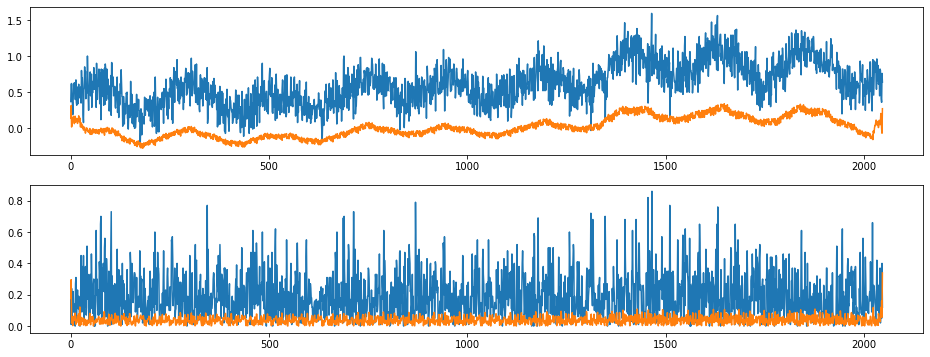

index:  117566
MAE:  0.600066862902313
n_bunches        656
bunch_index     1358
bunch_number     258
Name: 11498461, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6404/instability_data/06404_Inst_B1H_Q7_20171121_19h03m14s.h5


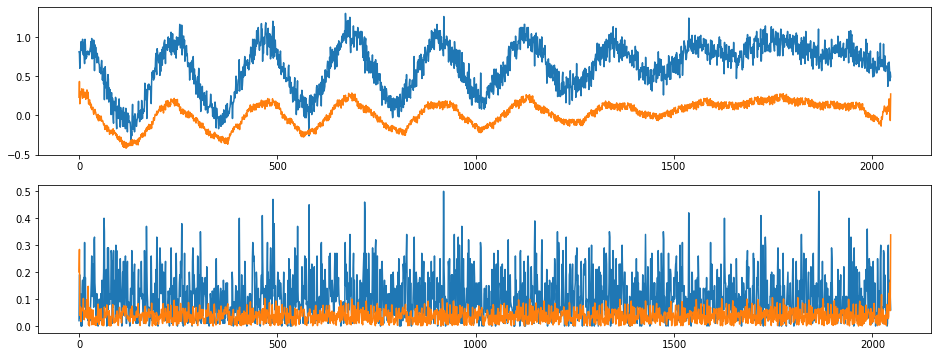

index:  75029
MAE:  0.5998536165023689
n_bunches       852
bunch_index     926
bunch_number    461
Name: 2416478, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7365/instability_data/07365_Inst_B1H_Q7_20181027_00h14m10s.h5


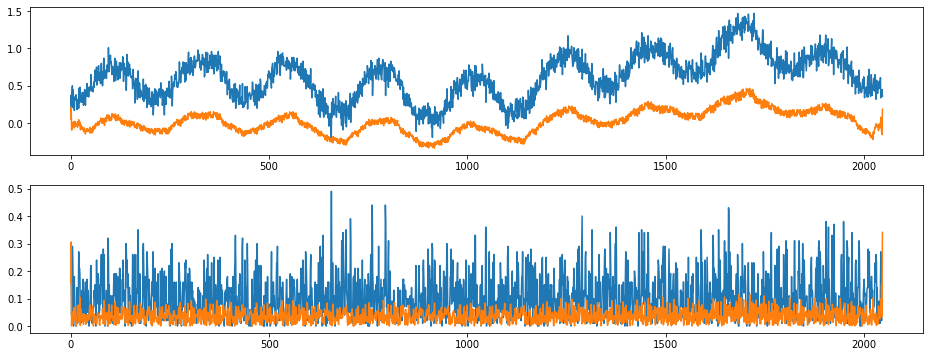

index:  11295
MAE:  0.5998244441387942
n_bunches       2556
bunch_index      831
bunch_number     586
Name: 4164162, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6709/instability_data/06709_Inst_B1H_Q7_20180520_23h53m14s.h5


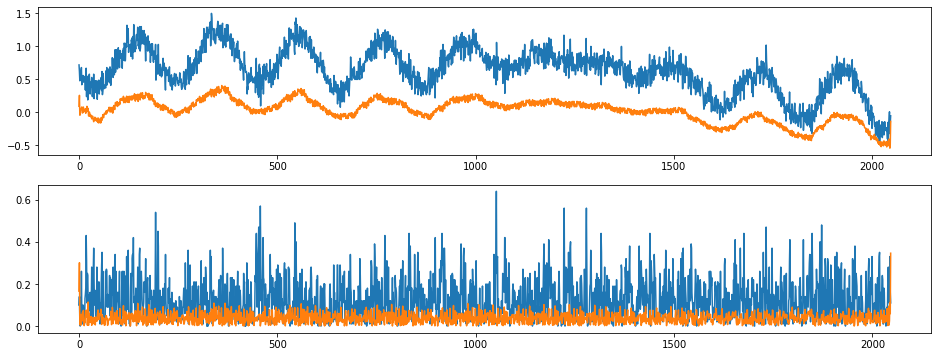

In [31]:
for i in range(10):
    around_point_index = around_point_indices[i]

    print('index: ', around_point_index)
    print("MAE: ", MAE_train[around_point_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_point_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_point_index].squeeze()
    pred_signal = train_pred[around_point_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# latent space encoding

In [32]:
import keras

In [33]:
encoding_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_2').output)

In [34]:
encoding_output = encoding_model(train_dataset[max_MAE_indices[-1]][None, :])
encoding_output.shape

TensorShape([1, 32, 8])

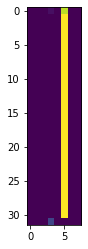

In [35]:
plt.imshow(np.array(encoding_output).squeeze())

# Latent space encoding of nominal signals

index:  392704
MAE:  0.022766299154609454
n_bunches        733
bunch_index     2291
bunch_number     484
Name: 1437707, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7467/instability_data/07467_Inst_B1H_Q7_20181123_10h37m15s.h5


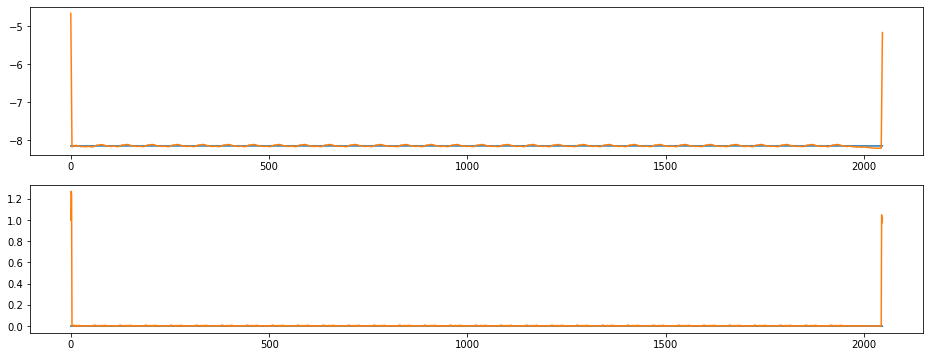

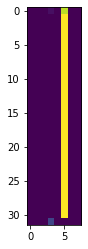

index:  391052
MAE:  0.022766299154609454
n_bunches       1868
bunch_index     2131
bunch_number    1139
Name: 1781577, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6348/instability_data/06348_Inst_B1H_Q7_20171031_01h41m14s.h5


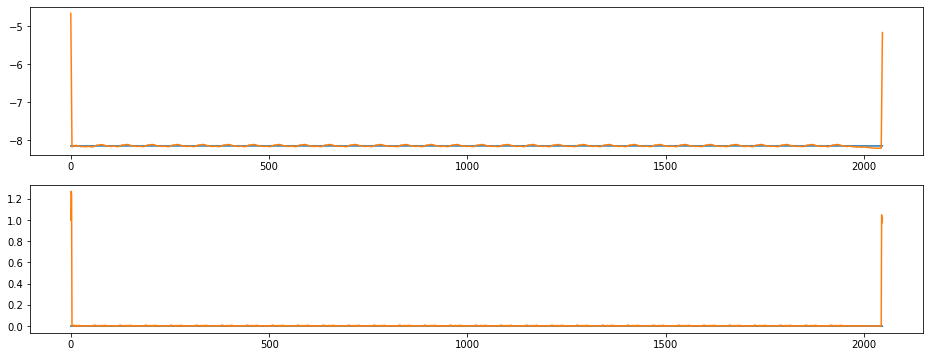

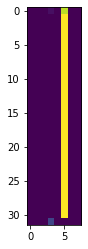

index:  391054
MAE:  0.022766299154609454
n_bunches       1868
bunch_index     2131
bunch_number    1139
Name: 1781577, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6348/instability_data/06348_Inst_B1H_Q7_20171031_01h41m14s.h5


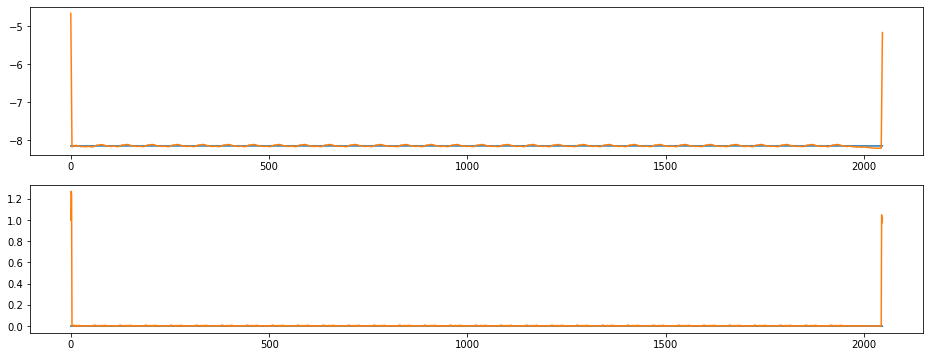

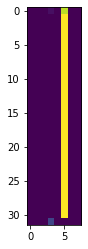

index:  386827
MAE:  0.022766299154609454
n_bunches       1212
bunch_index     1169
bunch_number     853
Name: 10664987, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7122/instability_data/07122_Inst_B1H_Q7_20180903_07h36m05s.h5


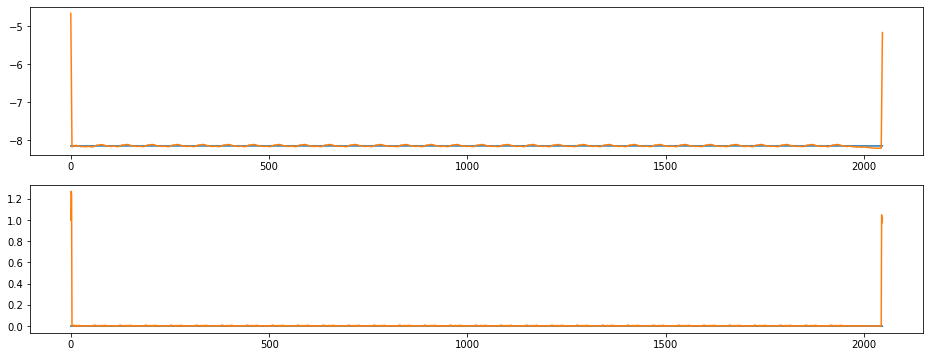

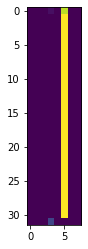

index:  388360
MAE:  0.022766299154609454
n_bunches       1551
bunch_index      555
bunch_number     351
Name: 4991367, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6628/instability_data/06628_Inst_B1H_Q7_20180501_03h41m14s.h5


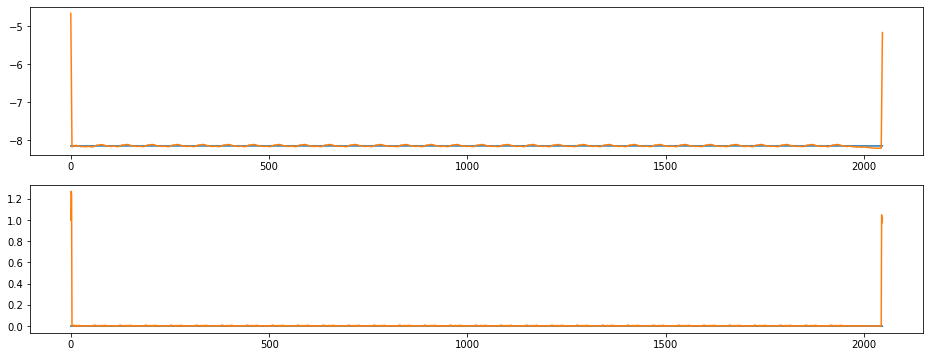

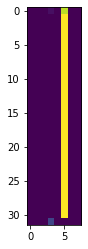

index:  390524
MAE:  0.022766299154609454
n_bunches       292
bunch_index     101
bunch_number     47
Name: 643337, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6254/instability_data/06254_Inst_B1H_Q7_20170929_05h24m15s.h5


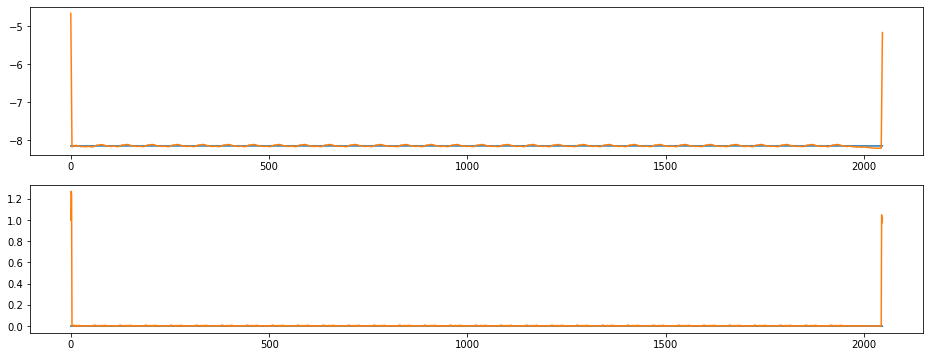

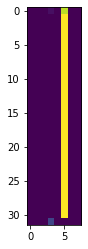

index:  387456
MAE:  0.022766299154609454
n_bunches       540
bunch_index     597
bunch_number    401
Name: 7797585, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6757/instability_data/06757_Inst_B1H_Q7_20180604_04h17m22s.h5


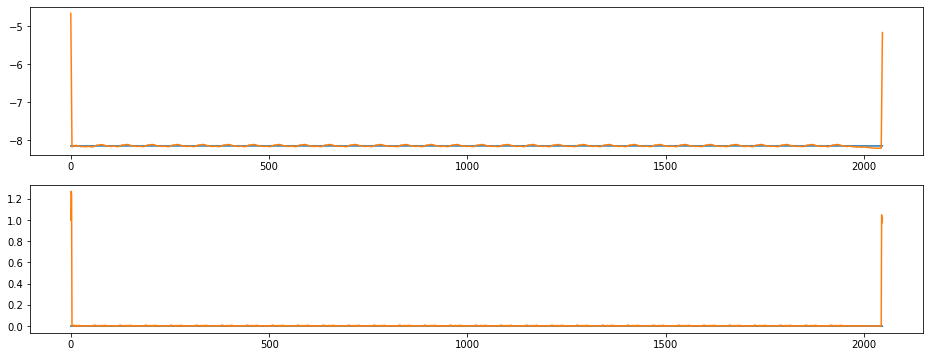

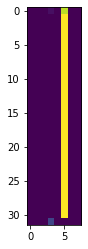

index:  387209
MAE:  0.022766299154609454
n_bunches       1068
bunch_index       24
bunch_number       6
Name: 1381145, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7117/instability_data/07117_Inst_B1H_Q7_20180902_03h37m59s.h5


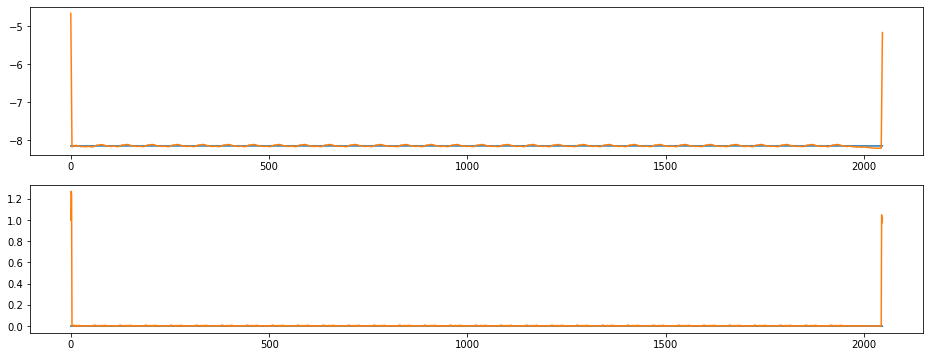

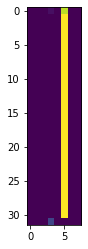

index:  388950
MAE:  0.022766299154609454
n_bunches       1068
bunch_index       83
bunch_number      15
Name: 299002, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6709/instability_data/06709_Inst_B1H_Q7_20180520_21h01m56s.h5


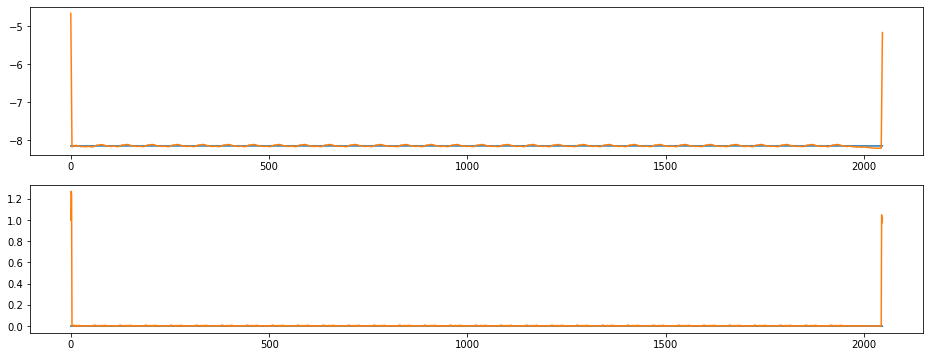

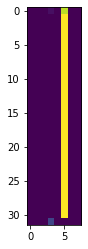

index:  387873
MAE:  0.022766299154609454
n_bunches       733
bunch_index      73
bunch_number     10
Name: 4972978, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7475/instability_data/07475_Inst_B1H_Q7_20181126_17h56m14s.h5


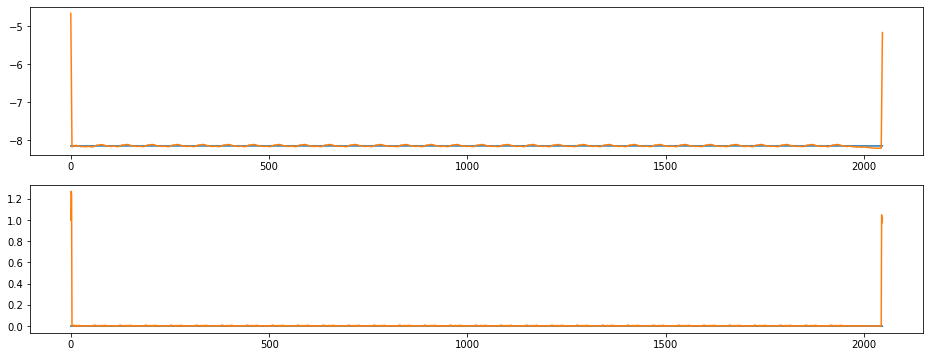

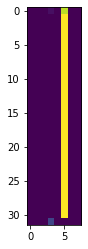

In [36]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]
    
    encoding_output = encoding_model(train_dataset[max_MAE_indices[left_most]][None, :])

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Latent space encoding of anomalous signals

index:  356654
MAE:  18.949226066423584
n_bunches       1188
bunch_index      909
bunch_number     488
Name: 6814885, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6184/instability_data/06184_Inst_B1H_Q7_20170909_23h52m01s.h5


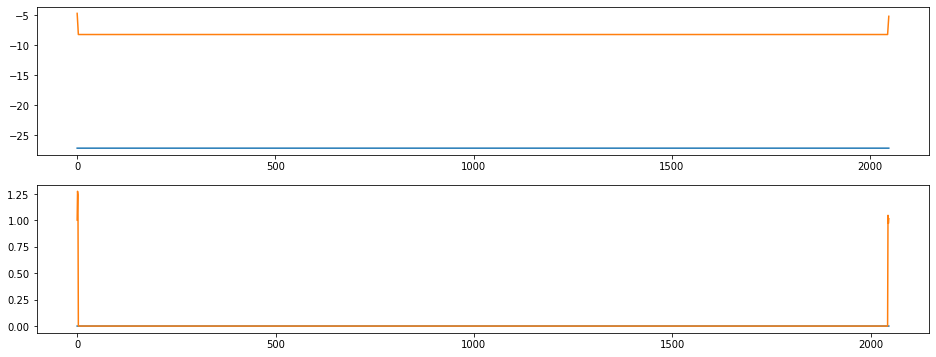

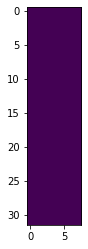

index:  359735
MAE:  18.949226066423584
n_bunches       524
bunch_index     610
bunch_number    113
Name: 1807058, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6381/instability_data/06381_Inst_B1H_Q7_20171112_08h01m20s.h5


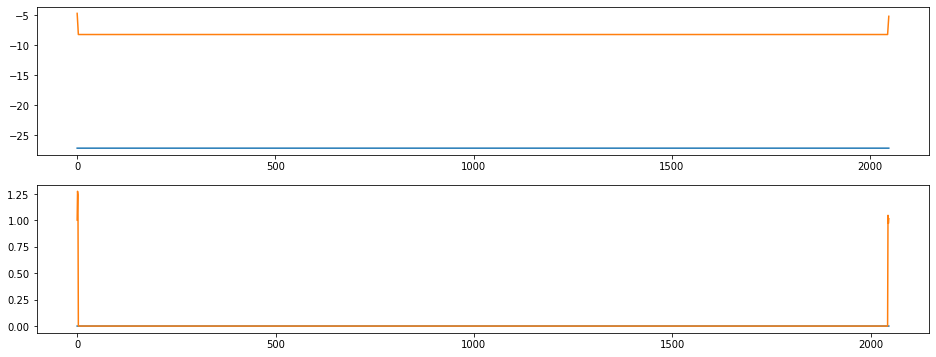

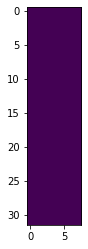

index:  60686
MAE:  17.578441255302174
n_bunches       2556
bunch_index     2213
bunch_number    1618
Name: 6406087, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6709/instability_data/06709_Inst_B1H_Q7_20180520_23h54m15s.h5


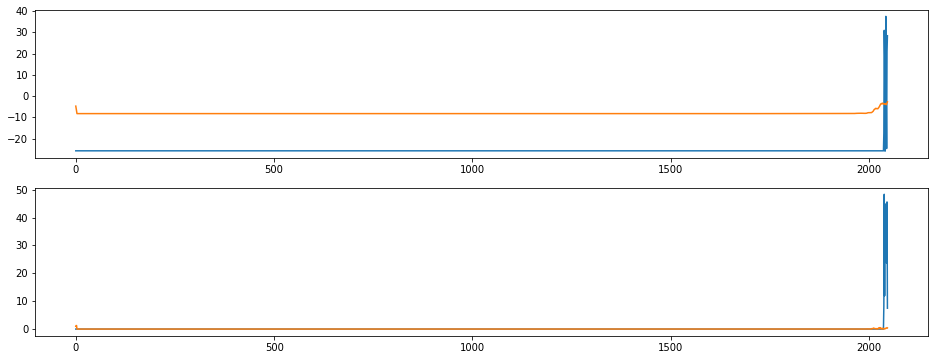

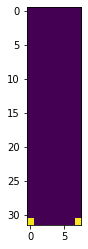

index:  63527
MAE:  17.51298751051538
n_bunches       924
bunch_index     529
bunch_number    364
Name: 1520834, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6738/instability_data/06738_Inst_B1H_Q7_20180529_00h10m07s.h5


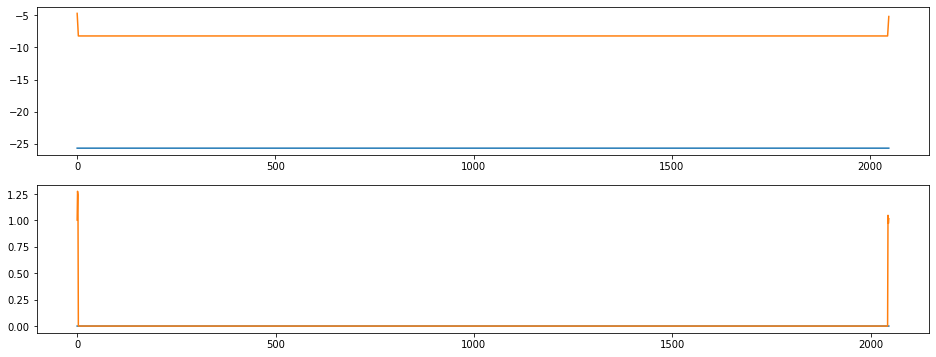

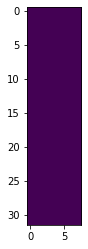

index:  60559
MAE:  17.51298751051538
n_bunches       2556
bunch_index     1419
bunch_number    1032
Name: 9992290, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_10h59m14s.h5


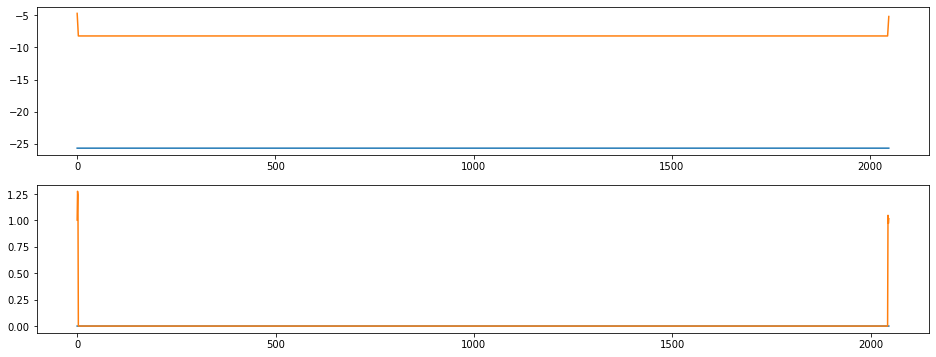

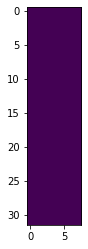

index:  59670
MAE:  17.51298751051538
n_bunches       540
bunch_index     925
bunch_number    277
Name: 9388191, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7182/instability_data/07182_Inst_B1H_Q7_20180915_17h48m02s.h5


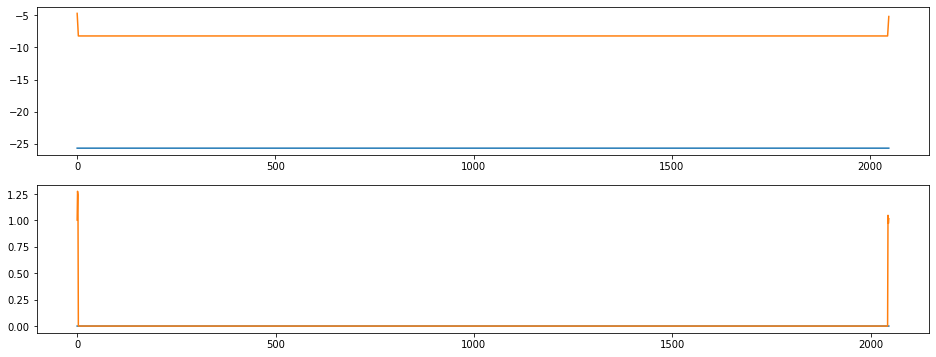

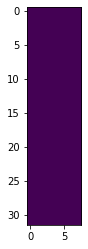

index:  63998
MAE:  17.51298751051538
n_bunches       2556
bunch_index      439
bunch_number     288
Name: 11208931, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6757/instability_data/06757_Inst_B1H_Q7_20180604_11h54m15s.h5


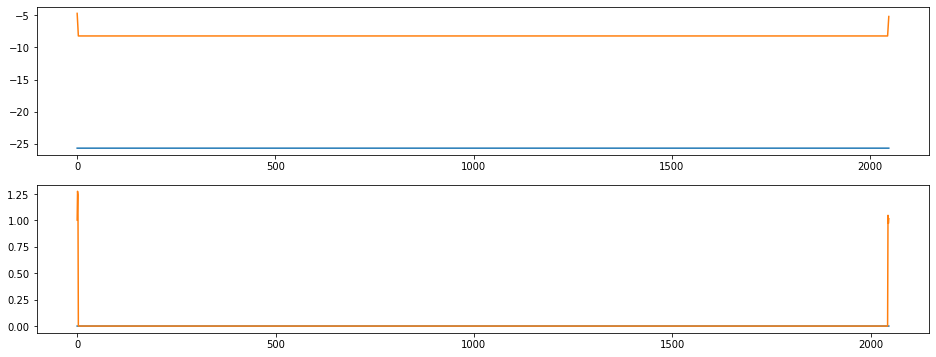

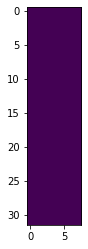

index:  62306
MAE:  17.51298751051538
n_bunches       1452
bunch_index     3296
bunch_number    1400
Name: 8205347, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180705_19h28m14s.h5


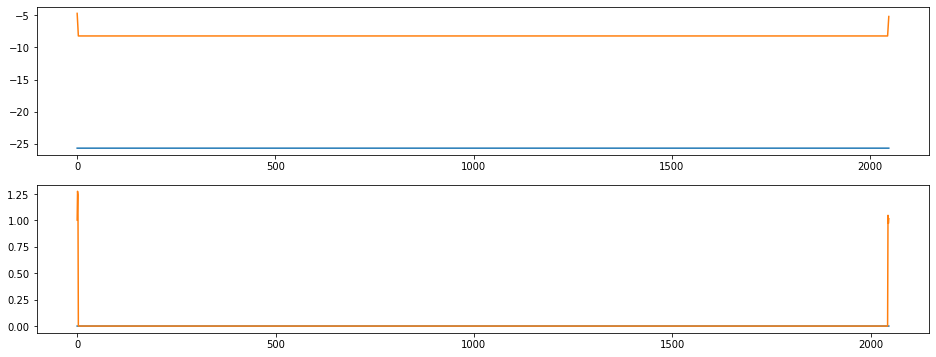

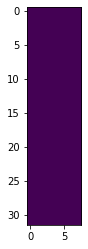

index:  377186
MAE:  16.827916709734126
n_bunches       780
bunch_index     283
bunch_number    189
Name: 845391, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7245/instability_data/07245_Inst_B1H_Q7_20181002_00h23m38s.h5


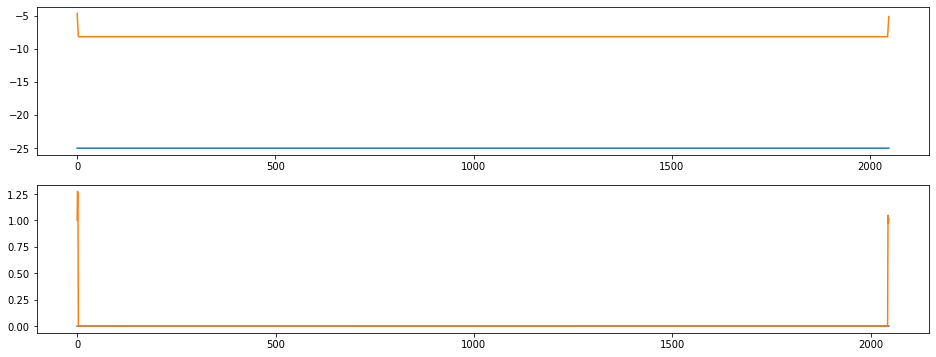

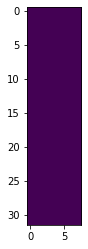

index:  380046
MAE:  16.827916709734126
n_bunches       1916
bunch_index     1328
bunch_number     727
Name: 11028177, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6243/instability_data/06243_Inst_B1H_Q7_20170925_21h04m59s.h5


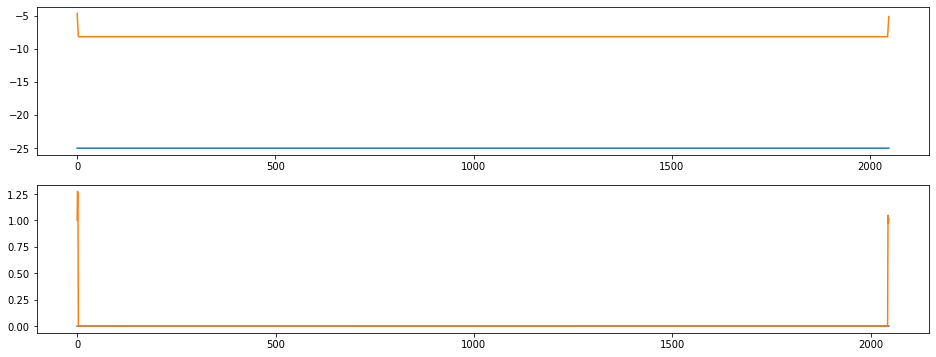

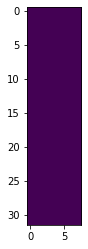

index:  301500
MAE:  15.70536208326928
n_bunches       444
bunch_index     527
bunch_number    285
Name: 9805972, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6988/instability_data/06988_Inst_B1H_Q7_20180727_04h59m15s.h5


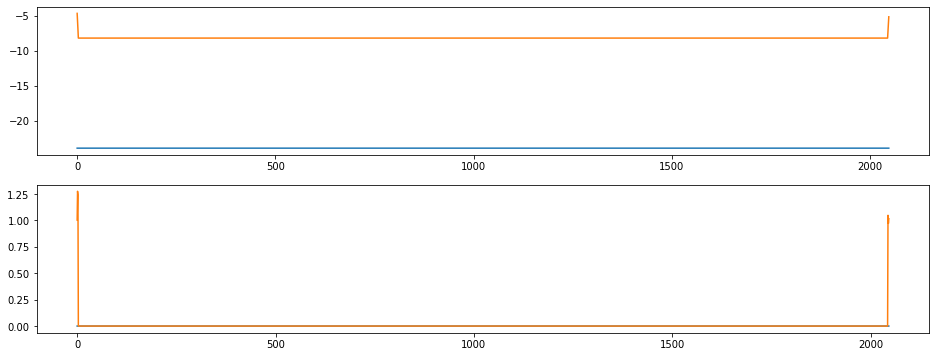

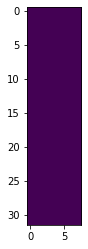

index:  295771
MAE:  15.70536208326928
n_bunches       459
bunch_index      95
bunch_number     14
Name: 9580620, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6614/instability_data/06614_Inst_B1H_Q7_20180426_03h00m14s.h5


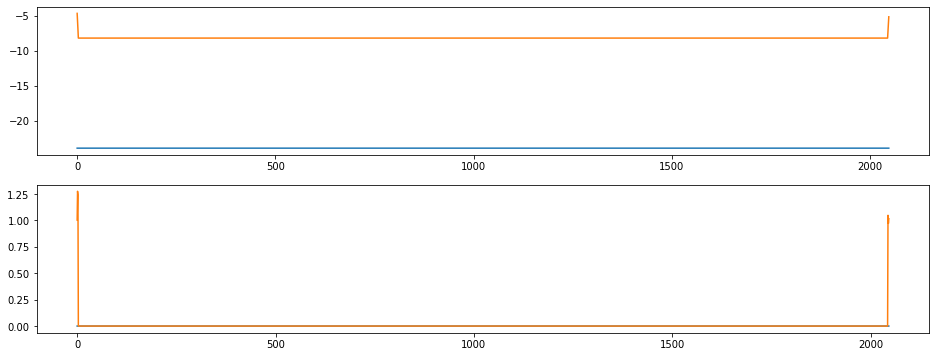

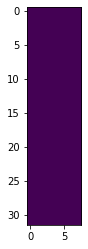

index:  296969
MAE:  15.70536208326928
n_bunches       1227
bunch_index     3244
bunch_number    1189
Name: 5742917, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_05h21m14s.h5


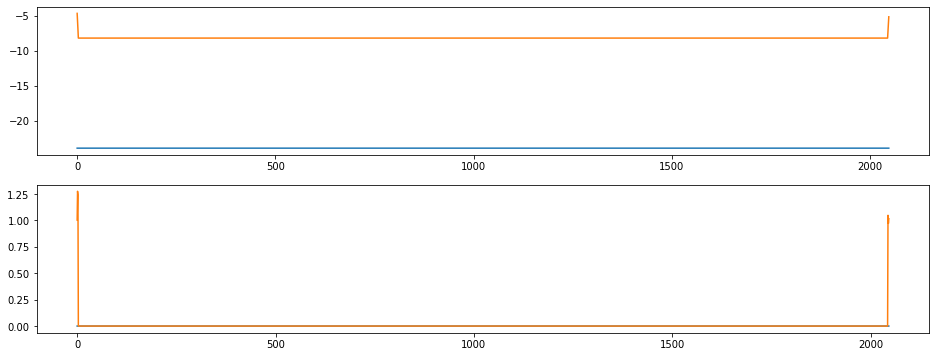

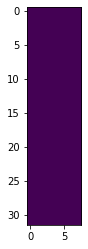

index:  263413
MAE:  15.699260856462644
n_bunches       924
bunch_index     847
bunch_number    595
Name: 951523, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6675/instability_data/06675_Inst_B1H_Q7_20180512_19h53m08s.h5


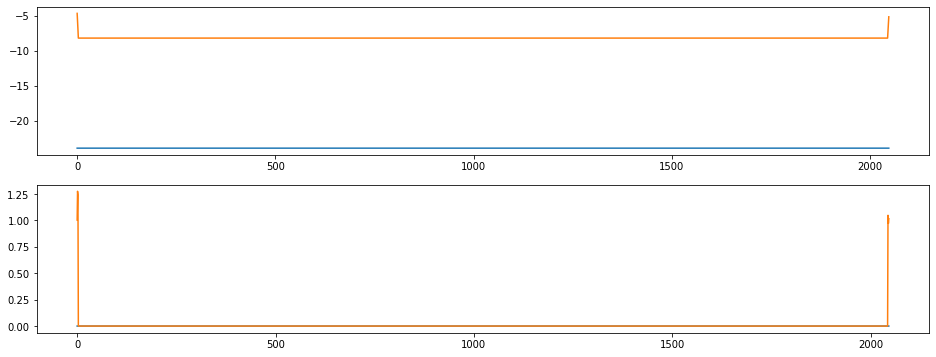

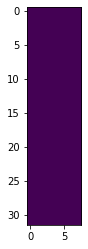

index:  269979
MAE:  15.699260856462644
n_bunches       2556
bunch_index     1747
bunch_number    1292
Name: 778215, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7333/instability_data/07333_Inst_B1H_Q7_20181023_08h30m14s.h5


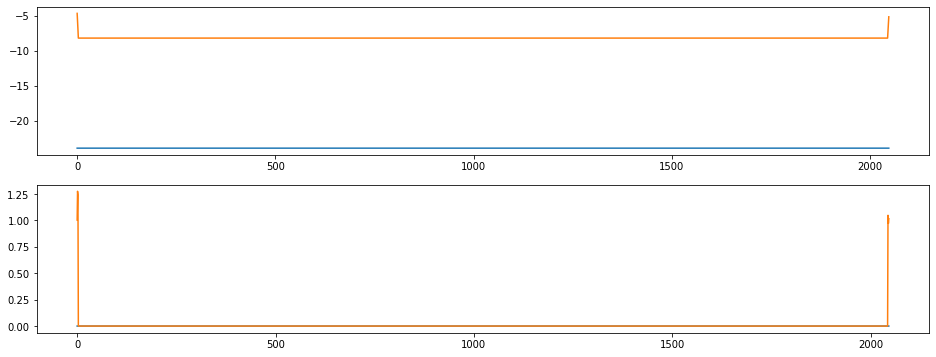

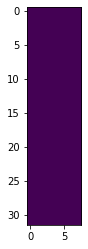

index:  50151
MAE:  15.145632926775138
n_bunches       493
bunch_index     567
bunch_number    415
Name: 697601, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6693/instability_data/06693_Inst_B1H_Q7_20180516_20h15m01s.h5


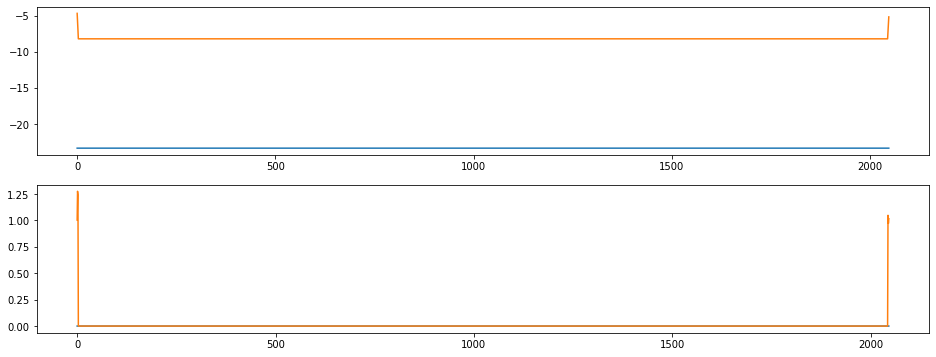

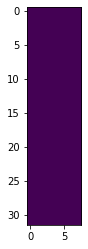

index:  50304
MAE:  15.145632926775138
n_bunches       648
bunch_index     195
bunch_number     34
Name: 11318555, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_08h22m15s.h5


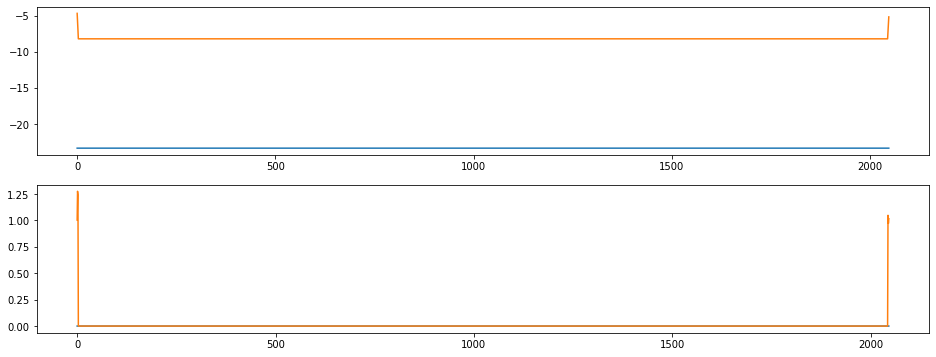

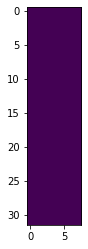

index:  51976
MAE:  15.145632926775138
n_bunches        324
bunch_index     1590
bunch_number     294
Name: 1904918, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7442/instability_data/07442_Inst_B1H_Q7_20181113_18h49m14s.h5


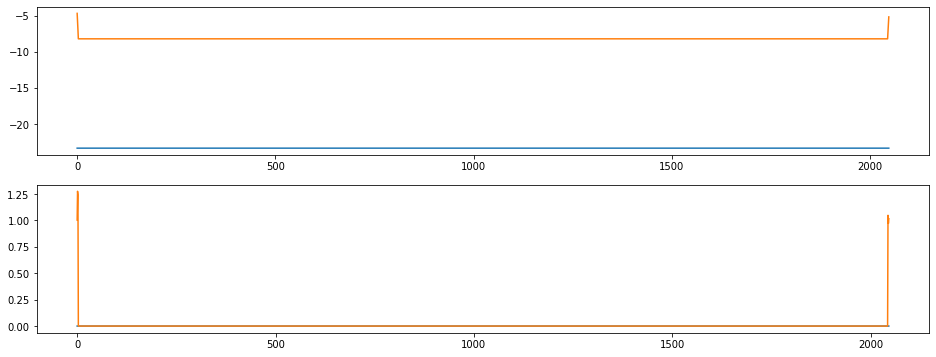

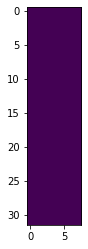

index:  54327
MAE:  15.145632926775138
n_bunches       1068
bunch_index      842
bunch_number     609
Name: 10437852, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7068/instability_data/07068_Inst_B1H_Q7_20180820_00h39m03s.h5


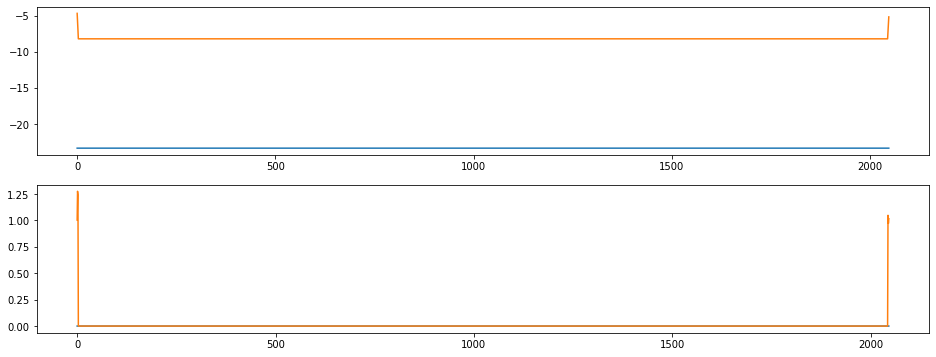

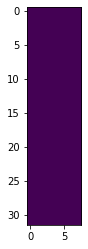

index:  229207
MAE:  15.009629356218504
n_bunches       780
bunch_index     725
bunch_number    534
Name: 8192537, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6924/instability_data/06924_Inst_B1H_Q7_20180715_08h15m46s.h5


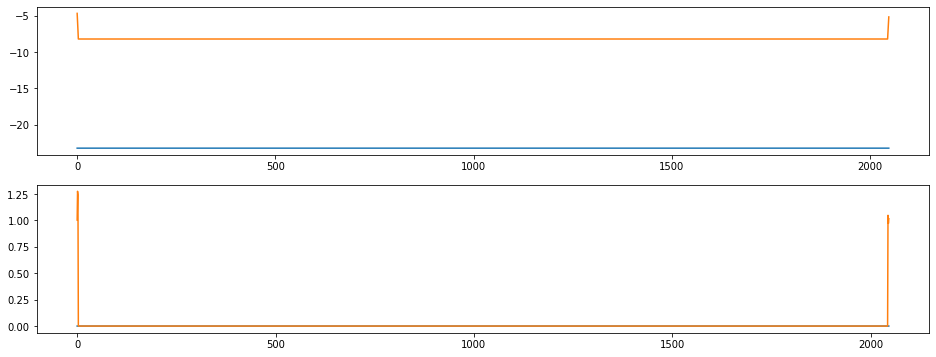

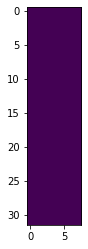

index:  228130
MAE:  15.009629356218504
n_bunches       2556
bunch_index      539
bunch_number     393
Name: 4259614, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7031/instability_data/07031_Inst_B1H_Q7_20180807_00h13m14s.h5


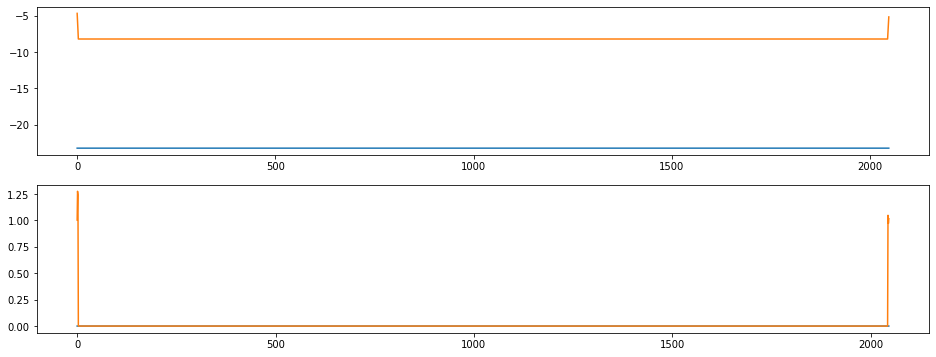

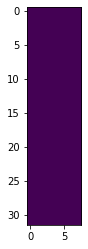

index:  222330
MAE:  15.009629356218504
n_bunches       828
bunch_index     727
bunch_number    526
Name: 3234192, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6900/instability_data/06900_Inst_B1H_Q7_20180708_01h58m27s.h5


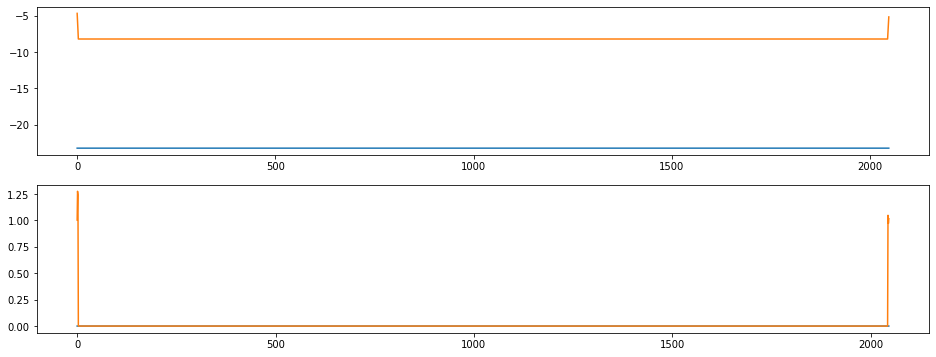

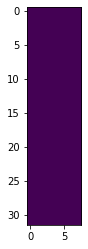

index:  228253
MAE:  15.009629356218504
n_bunches       2556
bunch_index     3111
bunch_number    2313
Name: 2918758, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7052/instability_data/07052_Inst_B1H_Q7_20180813_22h22m15s.h5


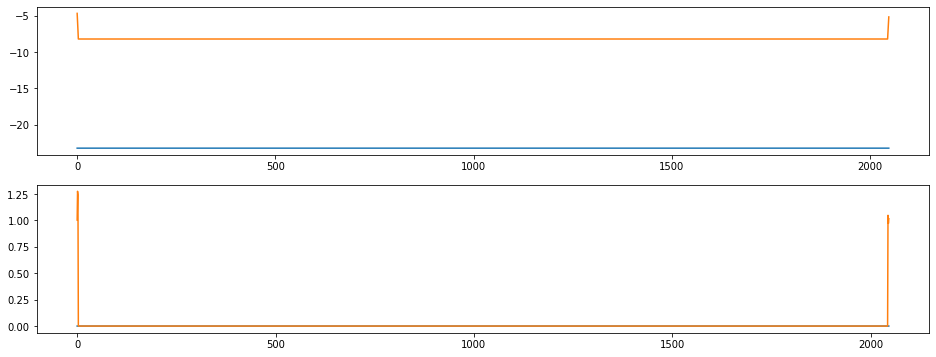

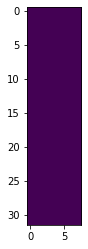

index:  136068
MAE:  14.91571623976342
n_bunches        362
bunch_index     2073
bunch_number     343
Name: 9295062, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6850/instability_data/06850_Inst_B1H_Q7_20180626_20h08m58s.h5


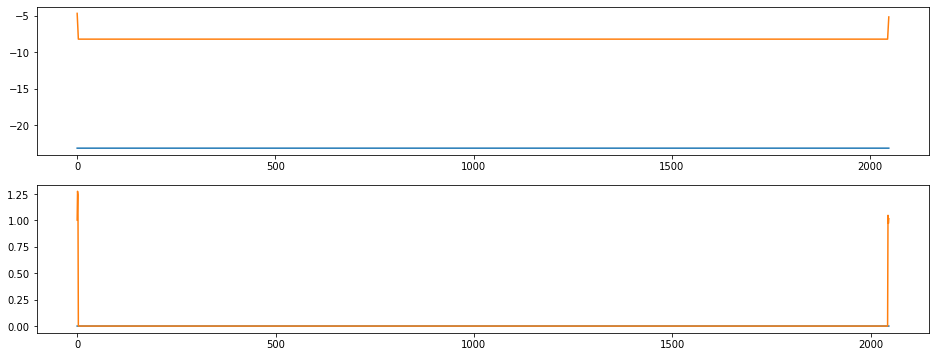

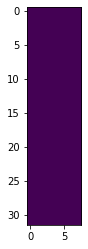

index:  137907
MAE:  14.91571623976342
n_bunches       780
bunch_index     327
bunch_number    226
Name: 2070744, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6911/instability_data/06911_Inst_B1H_Q7_20180711_10h01m59s.h5


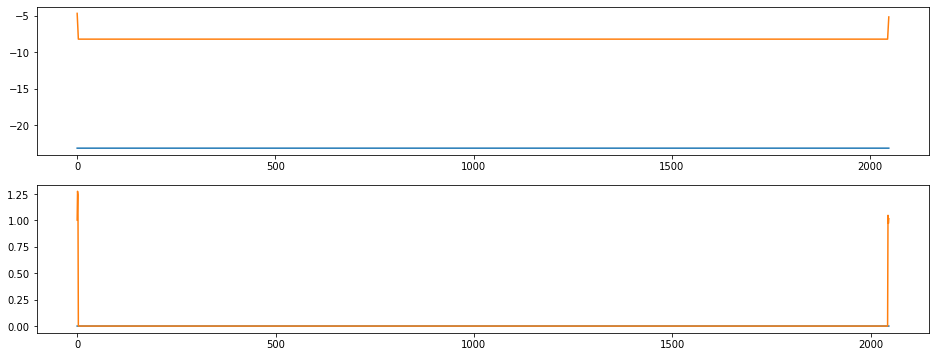

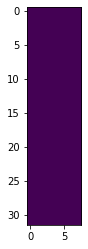

index:  133568
MAE:  14.91571623976342
n_bunches        268
bunch_index     1063
bunch_number     152
Name: 737577, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6381/instability_data/06381_Inst_B1H_Q7_20171112_07h49m53s.h5


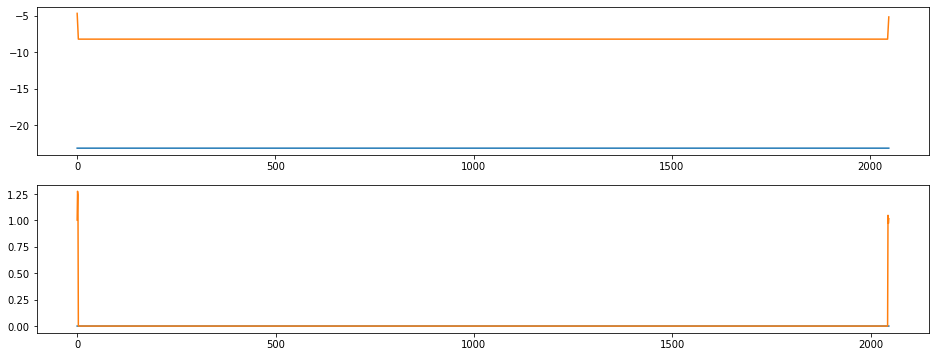

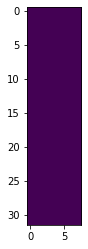

index:  138644
MAE:  14.91571623976342
n_bunches       572
bunch_index     823
bunch_number    449
Name: 4410174, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6246/instability_data/06246_Inst_B1H_Q7_20170927_05h49m15s.h5


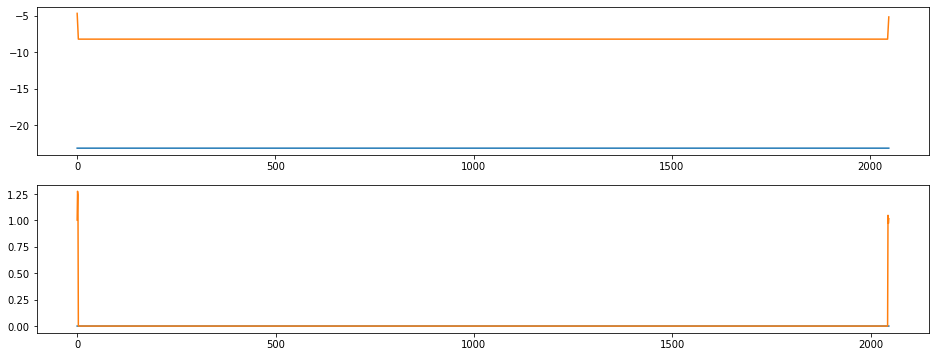

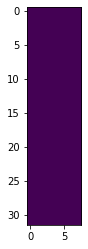

index:  136914
MAE:  14.91571623976342
n_bunches       649
bunch_index     173
bunch_number     49
Name: 2329246, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6854/instability_data/06854_Inst_B1H_Q7_20180627_21h41m31s.h5


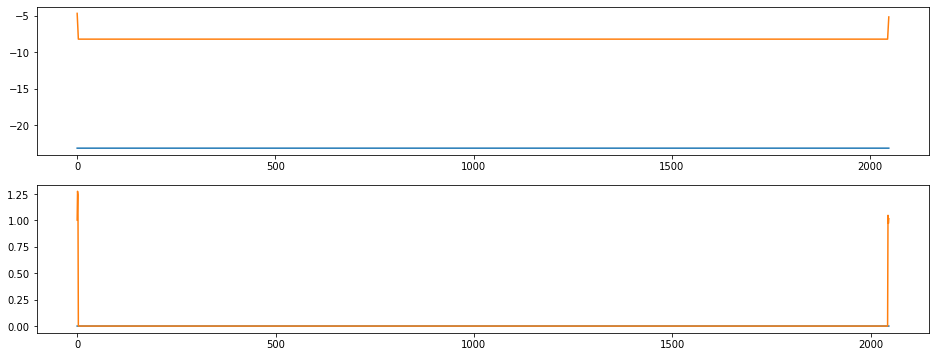

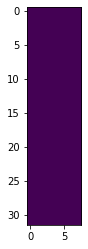

index:  76346
MAE:  14.666091911150145
n_bunches       1548
bunch_index     1294
bunch_number     567
Name: 4267424, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6399/instability_data/06399_Inst_B1H_Q7_20171121_03h08m14s.h5


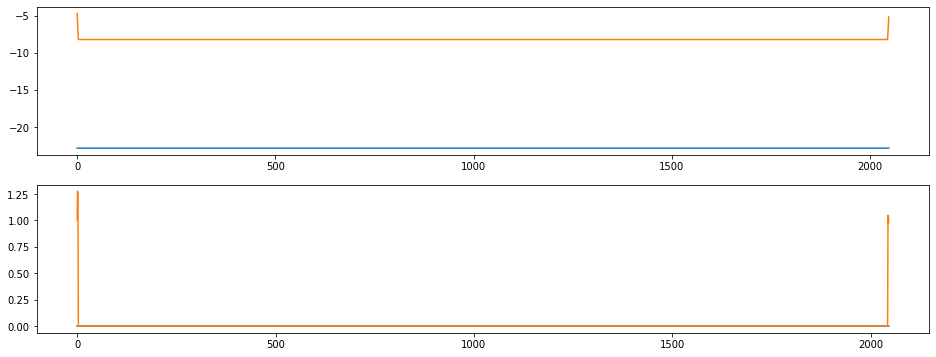

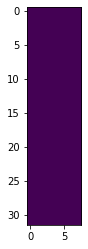

index:  77126
MAE:  14.666091911150145
n_bunches       180
bunch_index     323
bunch_number    175
Name: 5973013, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6246/instability_data/06246_Inst_B1H_Q7_20170927_04h41m02s.h5


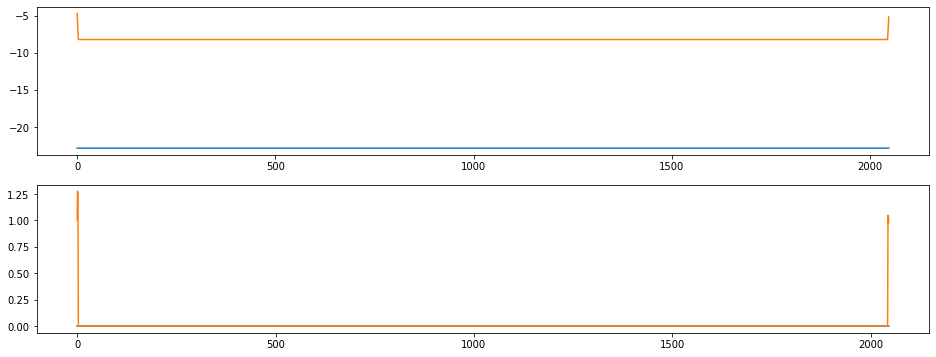

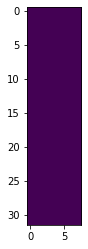

index:  81908
MAE:  14.666091911150145
n_bunches       636
bunch_index     868
bunch_number    635
Name: 5684325, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7137/instability_data/07137_Inst_B1H_Q7_20180908_02h11m24s.h5


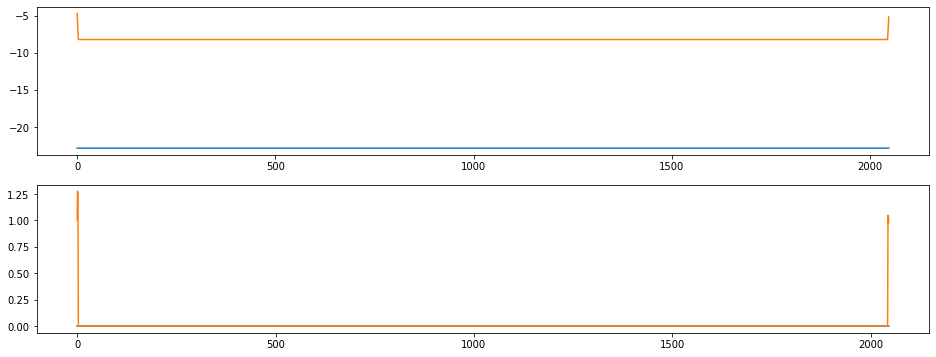

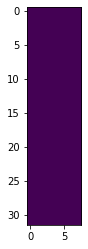

index:  75170
MAE:  14.666091911150145
n_bunches       1076
bunch_index      265
bunch_number     137
Name: 9015807, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6184/instability_data/06184_Inst_B1H_Q7_20170909_23h50m54s.h5


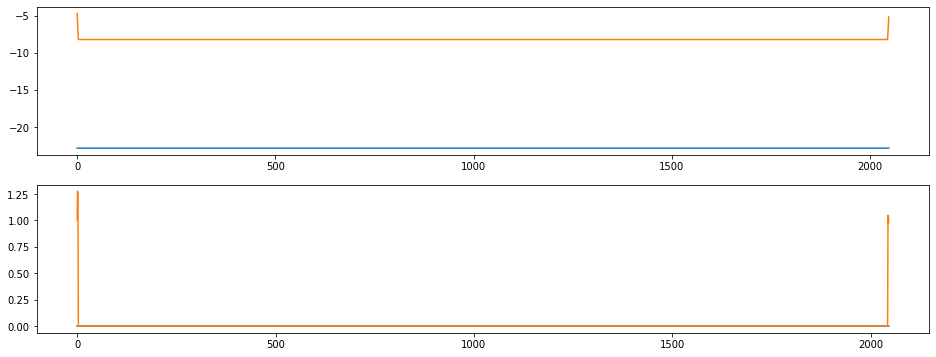

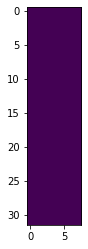

index:  79935
MAE:  14.666091911150145
n_bunches       172
bunch_index      63
bunch_number     26
Name: 10878604, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6363/instability_data/06363_Inst_B1H_Q7_20171105_20h48m19s.h5


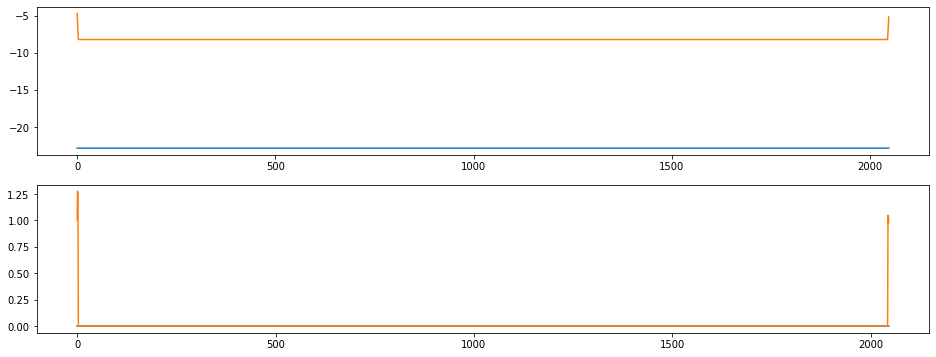

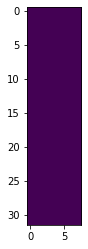

index:  78610
MAE:  14.666091911150145
n_bunches       2460
bunch_index     1707
bunch_number    1253
Name: 1560249, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6860/instability_data/06860_Inst_B1H_Q7_20180628_17h38m59s.h5


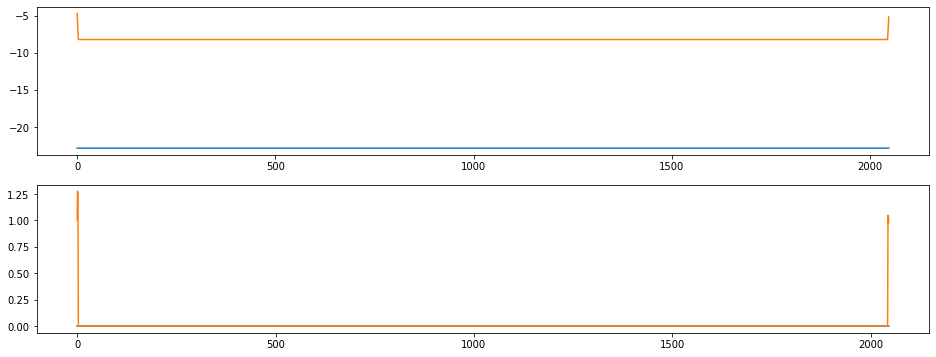

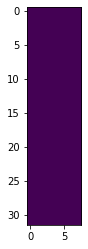

index:  354104
MAE:  14.129221641374754
n_bunches       169
bunch_index     372
bunch_number    109
Name: 6930235, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6849/instability_data/06849_Inst_B1H_Q7_20180626_18h00m48s.h5


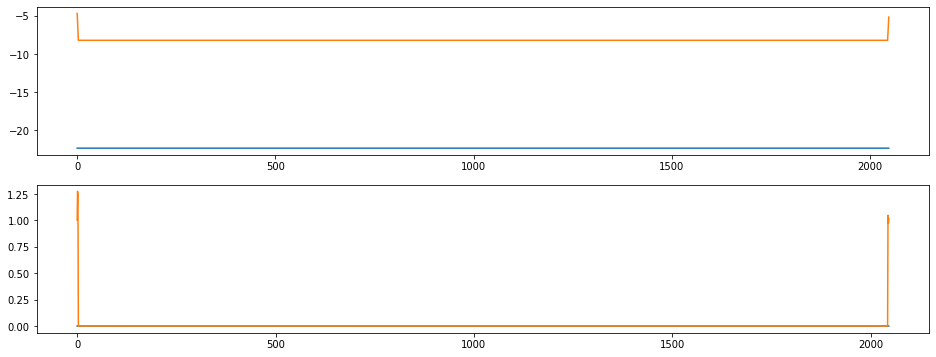

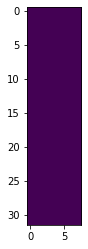

index:  357887
MAE:  14.129221641374754
n_bunches        652
bunch_index     1241
bunch_number     533
Name: 11419585, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6397/instability_data/06397_Inst_B1H_Q7_20171118_13h02m38s.h5


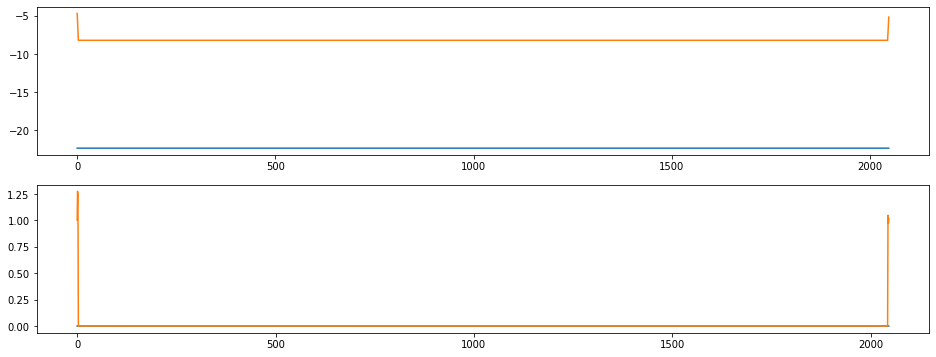

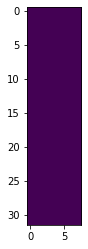

index:  355282
MAE:  14.129221641374754
n_bunches       1868
bunch_index     2534
bunch_number    1377
Name: 1731060, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6356/instability_data/06356_Inst_B1H_Q7_20171102_02h06m14s.h5


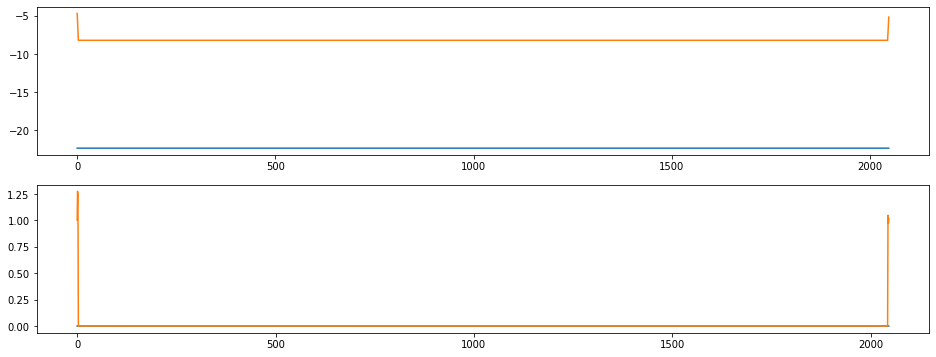

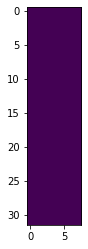

index:  356615
MAE:  14.129221641374754
n_bunches       396
bunch_index      23
bunch_number      5
Name: 4354513, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7087/instability_data/07087_Inst_B1H_Q7_20180825_13h04m11s.h5


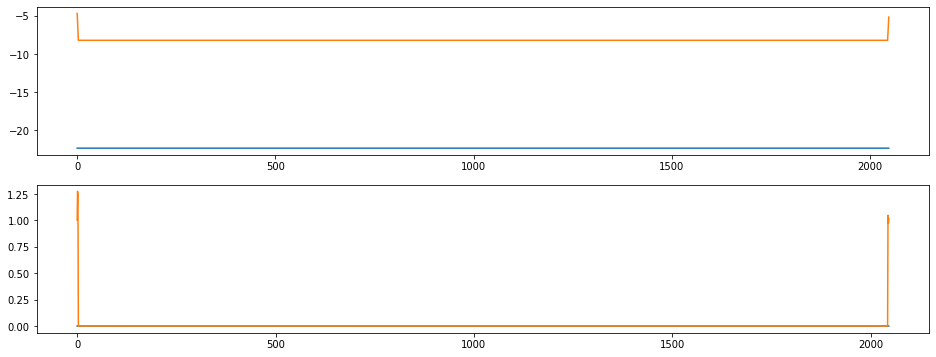

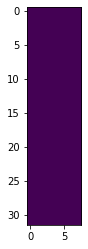

index:  353423
MAE:  14.129221641374754
n_bunches        565
bunch_index     2395
bunch_number     504
Name: 10046318, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7487/instability_data/07487_Inst_B1H_Q7_20181130_19h11m15s.h5


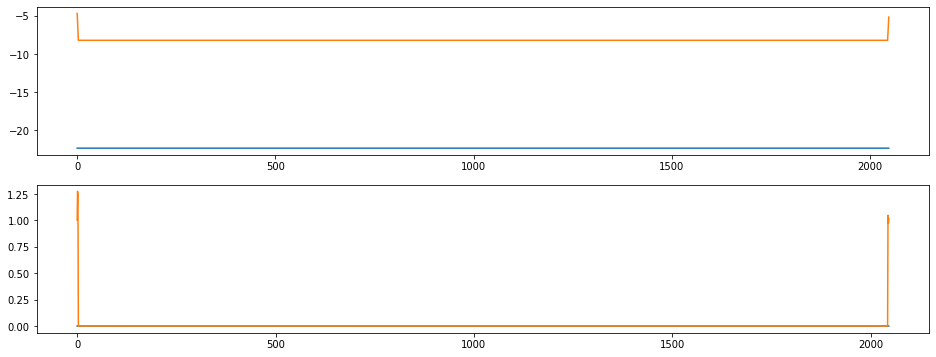

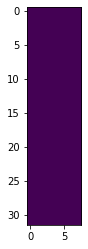

index:  358354
MAE:  14.129221641374754
n_bunches       1836
bunch_index      508
bunch_number     265
Name: 11241971, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_04h50m13s.h5


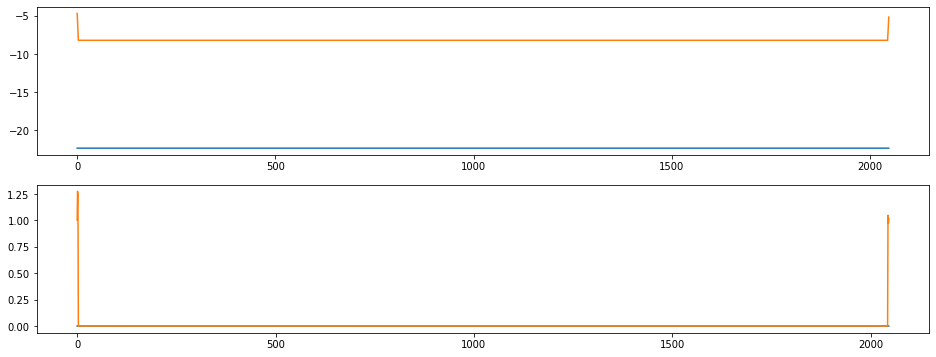

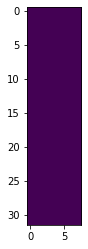

index:  133038
MAE:  13.627838377273871
n_bunches        987
bunch_index     2945
bunch_number     827
Name: 2357346, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6929/instability_data/06929_Inst_B1H_Q7_20180716_04h44m14s.h5


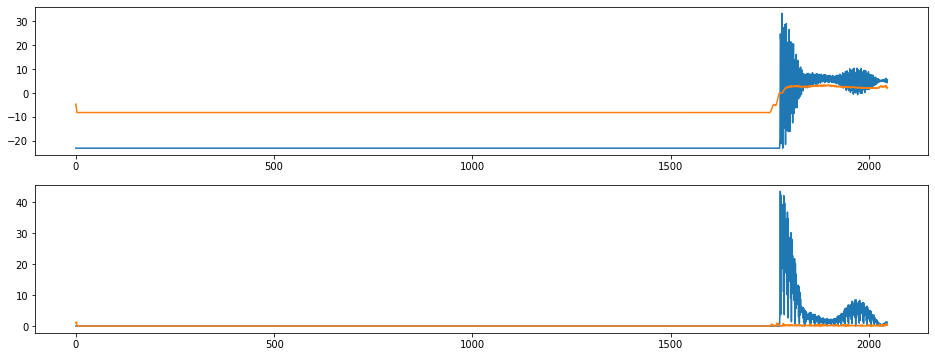

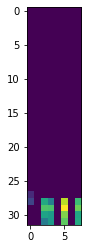

index:  295351
MAE:  13.331415523920729
n_bunches        733
bunch_index     2404
bunch_number     506
Name: 11189861, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7477/instability_data/07477_Inst_B1H_Q7_20181127_01h25m15s.h5


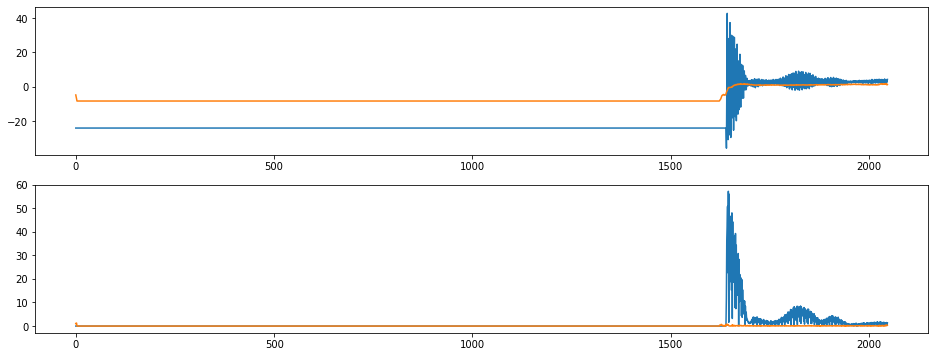

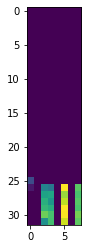

index:  403842
MAE:  12.835448448015372
n_bunches       876
bunch_index     702
bunch_number    511
Name: 8209221, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7157/instability_data/07157_Inst_B1H_Q7_20180913_01h46m12s.h5


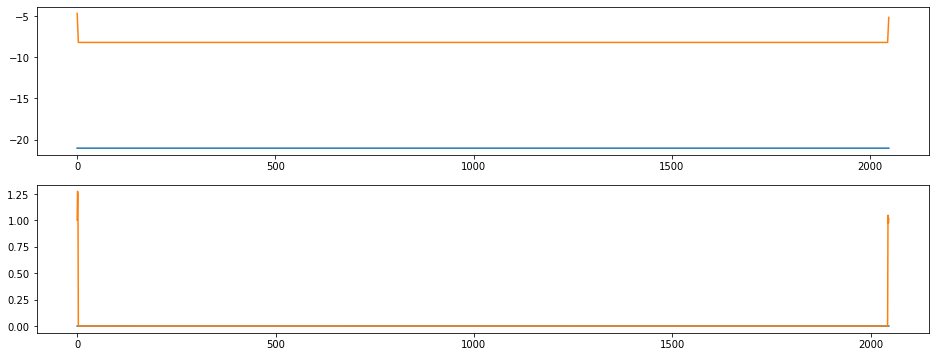

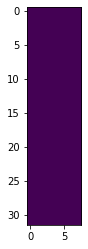

index:  402717
MAE:  12.835448448015372
n_bunches        228
bunch_index     1672
bunch_number     132
Name: 5479147, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7023/instability_data/07023_Inst_B1H_Q7_20180805_07h22m41s.h5


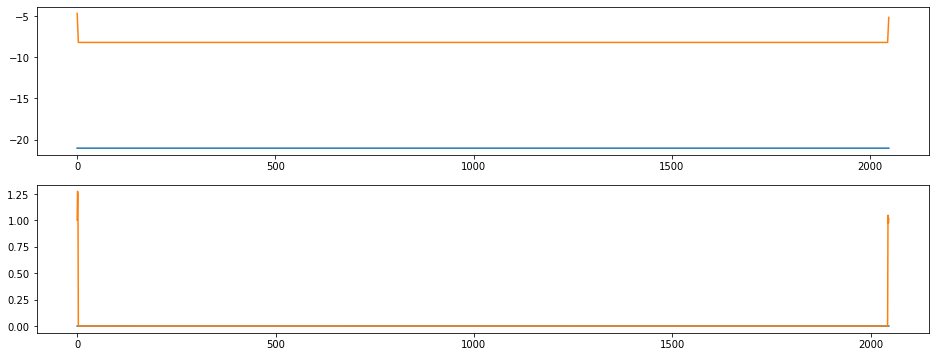

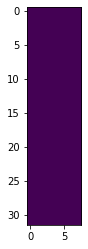

index:  407547
MAE:  12.835448448015372
n_bunches       1227
bunch_index      503
bunch_number     222
Name: 9371560, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_06h09m14s.h5


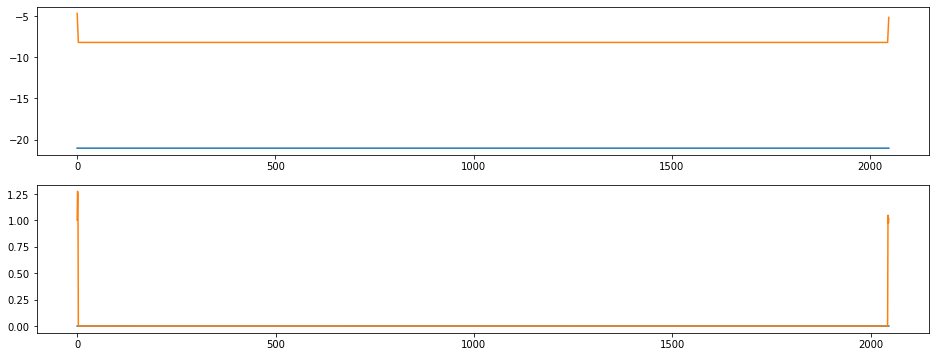

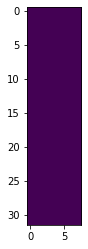

index:  409010
MAE:  12.835448448015372
n_bunches       1836
bunch_index     1795
bunch_number     930
Name: 1716086, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6389/instability_data/06389_Inst_B1H_Q7_20171115_09h22m13s.h5


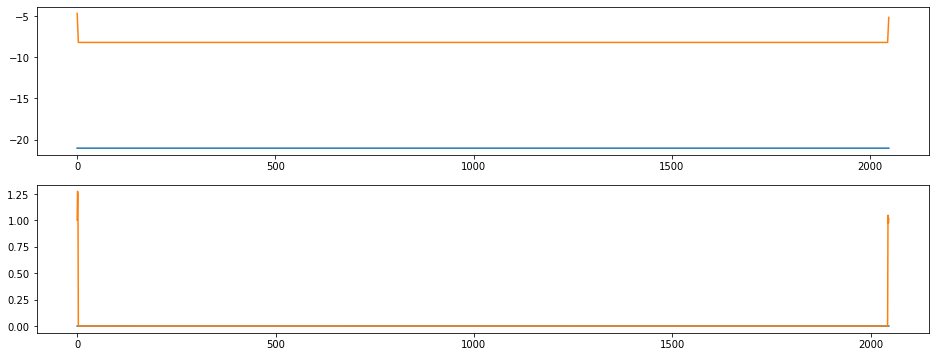

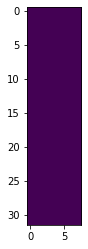

index:  404230
MAE:  12.835448448015372
n_bunches       1868
bunch_index     3076
bunch_number    1651
Name: 7596171, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6358/instability_data/06358_Inst_B1H_Q7_20171102_18h13m14s.h5


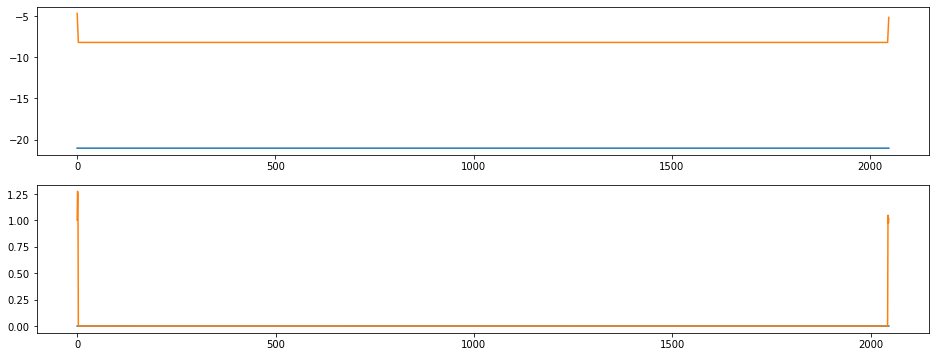

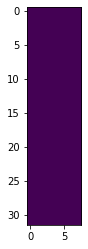

index:  401520
MAE:  12.835448448015372
n_bunches       1836
bunch_index     1351
bunch_number     713
Name: 5059670, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_09h39m14s.h5


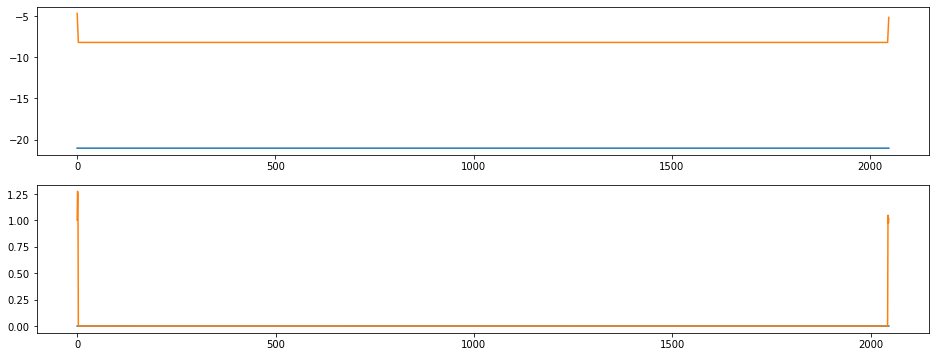

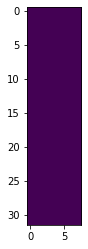

index:  379627
MAE:  12.762866867695557
n_bunches        408
bunch_index     1072
bunch_number     140
Name: 7809319, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6436/instability_data/06436_Inst_B1H_Q7_20171130_06h26m24s.h5


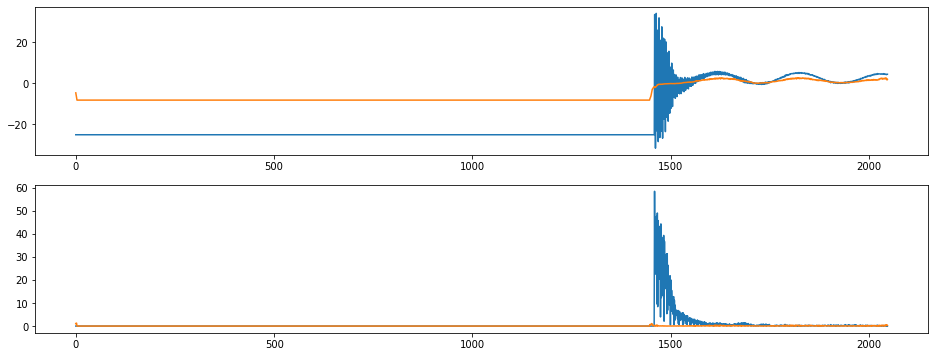

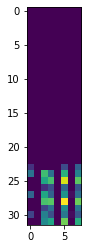

index:  341056
MAE:  12.670549003435298
n_bunches       1068
bunch_index     1264
bunch_number     922
Name: 3756856, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6741/instability_data/06741_Inst_B1H_Q7_20180530_10h08m43s.h5


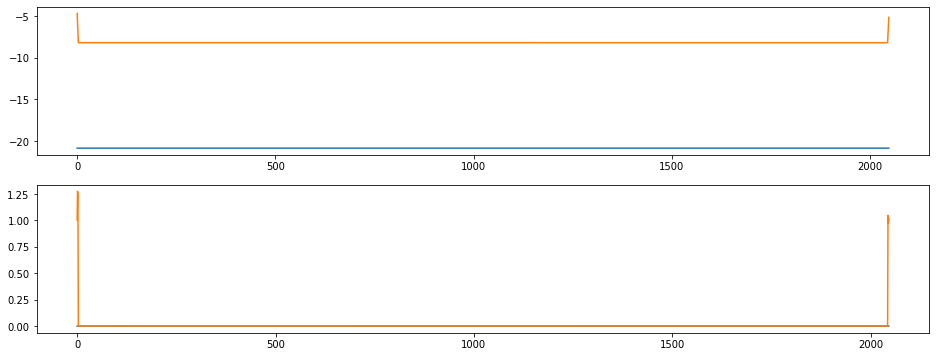

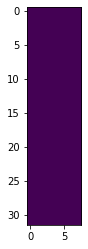

In [37]:
for i in range(50):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    
    encoding_output = encoding_model(train_dataset[anomalous_index][None, :])

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()